# Steering Analysis

Analysis of steering results, plotting log probability trajectories by role and steering magnitude.

In [1]:
import ast
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Configuration
DATA_FOLDER = '../data/Qwen3-30B-A3B-Instruct-2507/role_responses/'
ROLEWISE_PLOTS = 'avg_response.csv'
ALL_FILES = ALL_FILES = ['avg_response.csv', 'avg_response_first_10.csv', 
             'avg_response_sys_diff.csv', 'avg_response_first_10_sys_diff.csv', 
             'at_role_response.csv', 'at_role_period_response.csv']
LOGPROBS_SYS_PATH = '../../logits/data/Qwen3-30B-A3B-Instruct-2507/logprobs_with_sys.csv'
LOGPROBS_NO_SYS_PATH = '../../logits/data/Qwen3-30B-A3B-Instruct-2507/logprobs_no_sys.csv'
OUTPUT_DIR = 'plots'


# Load selected words with group labels
words_df = pd.read_csv('../../../data/selected_words.csv')

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Load Data
df = pd.read_csv(DATA_FOLDER + ROLEWISE_PLOTS)
print(f"Loaded steering data shape: {df.shape}")
print(f"steering layers: {df.steered_layers[0]}")

# Load unsteered logprobs data
df_logits_sys = pd.read_csv(LOGPROBS_SYS_PATH)
df_logits_no_sys = pd.read_csv(LOGPROBS_NO_SYS_PATH)
print(f"Loaded unsteered sys logprobs shape: {df_logits_sys.shape}")
print(f"Loaded unsteered no-sys logprobs shape: {df_logits_no_sys.shape}")

# Parse logprobs
def parse_list(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except:
            return []
    return x

df['first_100_response_log_probs'] = df['first_100_response_log_probs'].apply(parse_list)
df_logits_sys['first_100_response_log_probs'] = df_logits_sys['first_100_response_log_probs'].apply(parse_list)
df_logits_no_sys['first_100_response_log_probs'] = df_logits_no_sys['first_100_response_log_probs'].apply(parse_list)
print("Parsed logprobs columns.")

print(df.columns)

Loaded steering data shape: (50000, 10)
steering layers: [np.int64(26), np.int64(30), np.int64(34), np.int64(38)]
Loaded unsteered sys logprobs shape: (6300, 8)
Loaded unsteered no-sys logprobs shape: (6300, 8)
Parsed logprobs columns.
Index(['role_name', 'task_name', 'sample_idx', 'average_log_probs',
       'role_log_probs', 'role_period_log_prob',
       'first_100_response_log_probs', 'first_100_response_text_len',
       'steering_magnitude', 'steered_layers'],
      dtype='object')


In [3]:
def get_avg_trajectory(series_of_lists):
    # Find max length
    if len(series_of_lists) == 0:
        return np.array([])

    # Create a matrix
    # We assume max length 100 based on column name, but let's be safe
    matrix = np.full((len(series_of_lists), 100), np.nan)
    for i, lst in enumerate(series_of_lists):
        if isinstance(lst, list) and len(lst) > 0:
            length = min(len(lst), 100)
            matrix[i, :length] = lst[:length]

    return np.nanmean(matrix, axis=0)

# Get unique roles
roles = df['role_name'].unique()
print(f"Found {len(roles)} unique roles.")

Found 125 unique roles.


In [4]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def trace_plot(df_steer, name, df_logits_sys, df_logits_no_sys, normalize = False):

    # Get unique magnitudes and sort them
    magnitudes = sorted(df_steer['steering_magnitude'].unique())

    if len(magnitudes) == 0:
        return

    fig, ax = plt.subplots(figsize=(12, 8))

    # Setup colormap
    # Normalize magnitudes to 0-1 for colormap
    norm = mcolors.Normalize(vmin=min(magnitudes), vmax=max(magnitudes))
    cmap = cm.viridis


    # Get unsteered anchor points
    role_logits_sys = df_logits_sys[df_logits_sys['role_name'].isin(df_steer['role_name'])]
    role_logits_no_sys = df_logits_no_sys[df_logits_no_sys['role_name'].isin(df_steer['role_name'])]
    if len(role_logits_sys) > 0:
        anchor_sys = get_avg_trajectory(role_logits_sys['first_100_response_log_probs'])
    if len(role_logits_no_sys) > 0:
        anchor_no_sys = get_avg_trajectory(role_logits_no_sys['first_100_response_log_probs'])

    if normalize:
        anchor_sys = anchor_sys - anchor_no_sys

    # Plot steering trajectories
    for mag in magnitudes:
        mag_df = df_steer[df_steer['steering_magnitude'] == mag]
        avg_traj = get_avg_trajectory(mag_df['first_100_response_log_probs'])
        if normalize:
            avg_traj = (avg_traj - anchor_no_sys) / anchor_sys

        if len(avg_traj) > 0:
            color = cmap(norm(mag))
            ax.plot(avg_traj, color=color, label=f'Mag: {mag}', alpha=0.7)

    if len(anchor_sys) > 0:
        if normalize:
            anchor_sys = anchor_sys / anchor_sys
        ax.plot(anchor_sys, color='red', linestyle='--', linewidth=2, label='Unsteered (with sys)', alpha=0.8)

    if len(anchor_no_sys) > 0:
        if normalize:
            anchor_no_sys = anchor_no_sys - anchor_no_sys
        ax.plot(anchor_no_sys, color='blue', linestyle='--', linewidth=2, label='Unsteered (no sys)', alpha=0.8)

    ax.set_title(f'Log Prob Trajectory for Group: {name}')
    ax.set_xlabel('Token Position')
    if normalize:
        ax.set_ylabel("Proportion of with_sys - without_sys log probabilities")
    else:
        ax.set_ylabel('Average Log Probability')
    if normalize:
        ax.set_ylim(-4,1)
    else:
        ax.set_ylim(-15, 0) # Consistent y-axis as per logits_results.ipynb

    # Add colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label='Steering Magnitude')

    # Add legend for anchor points (placed below colorbar)
    ax.legend(loc='upper right', bbox_to_anchor=(0.98, 0.85))

    plt.tight_layout()

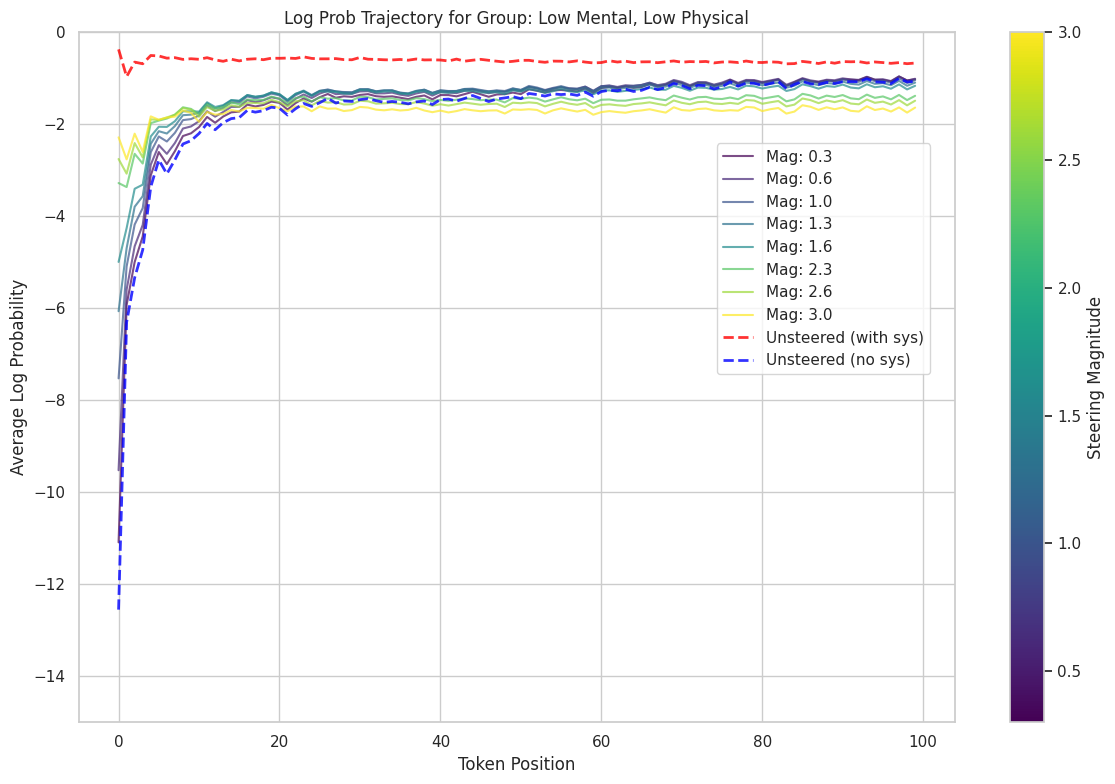

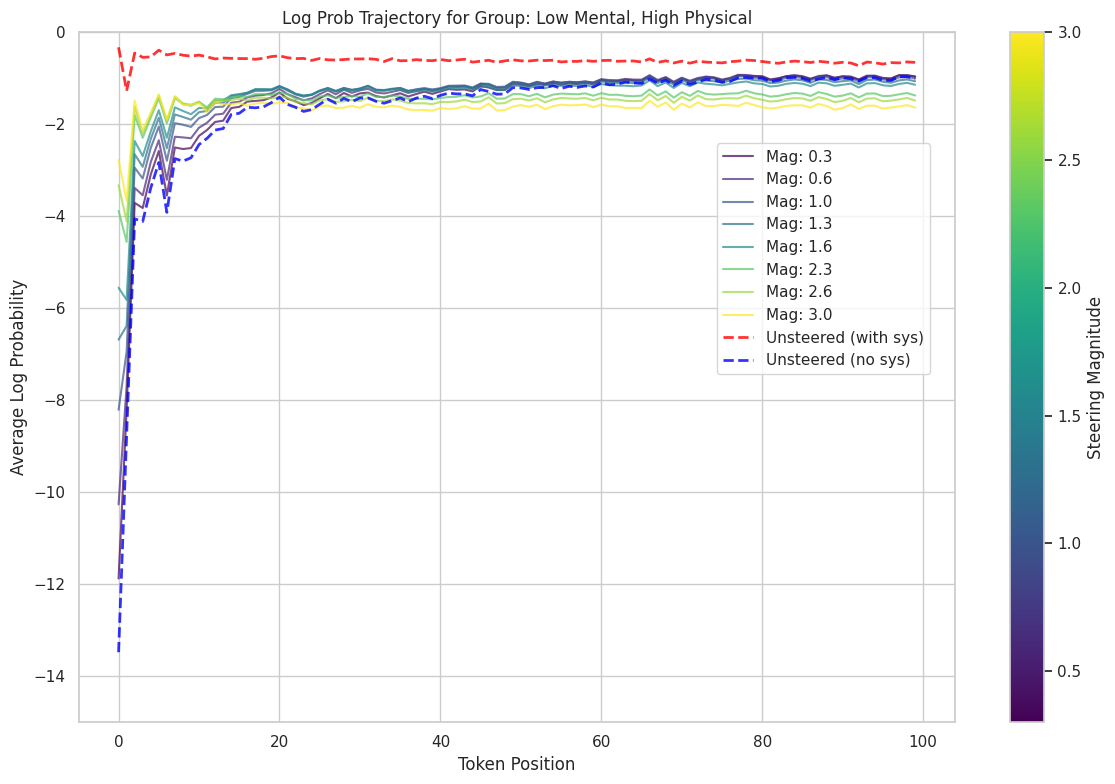

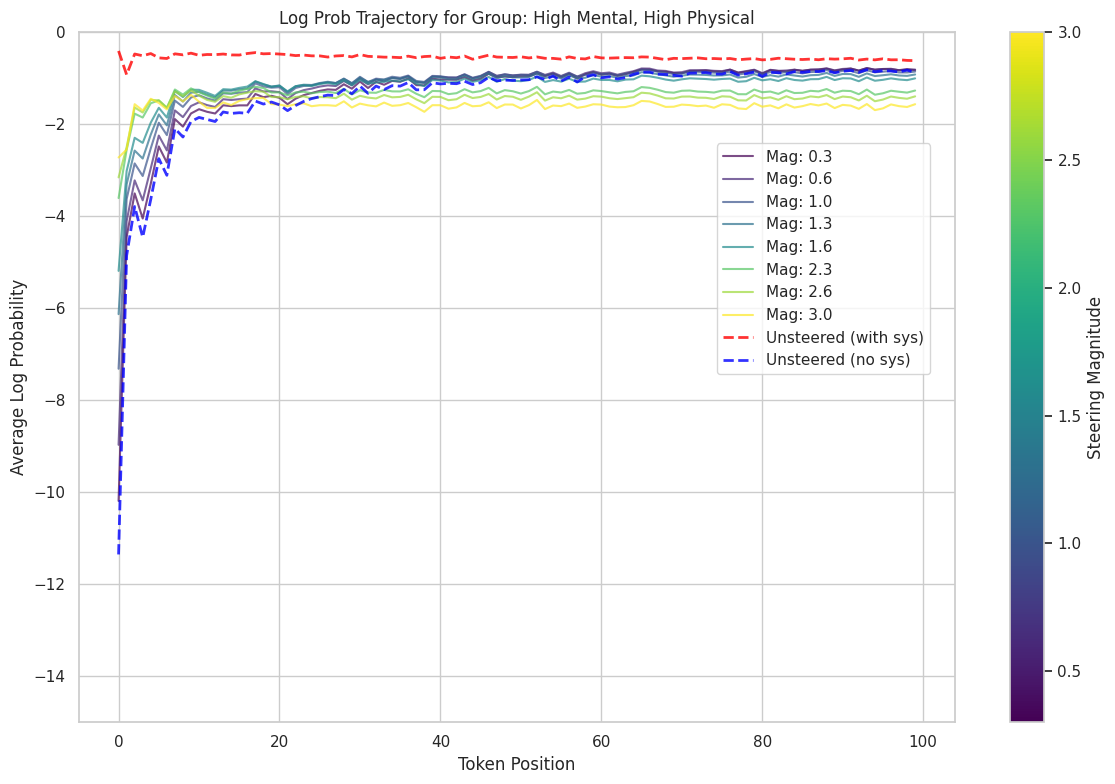

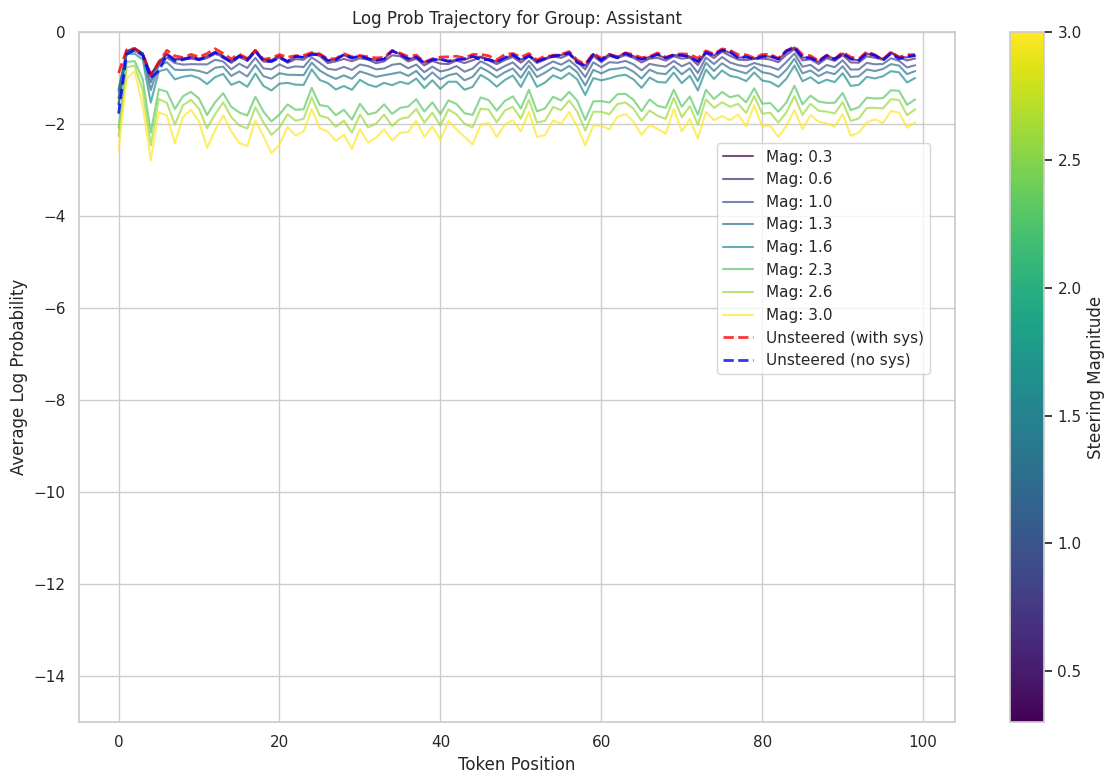

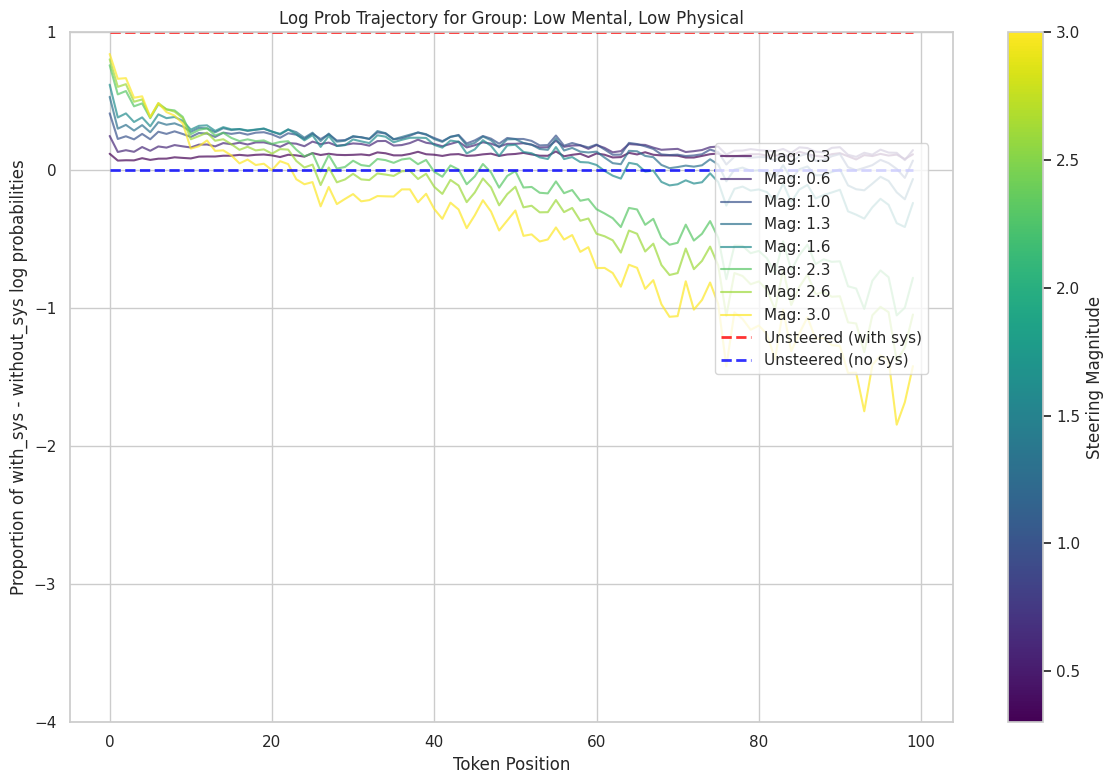

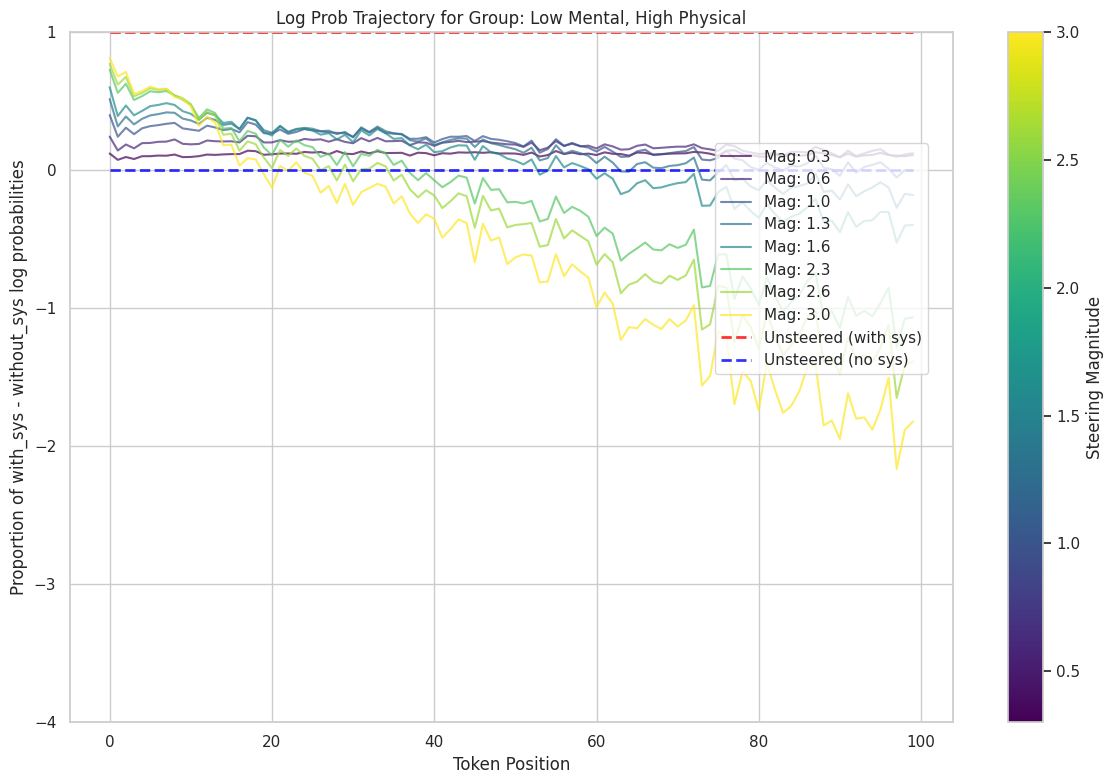

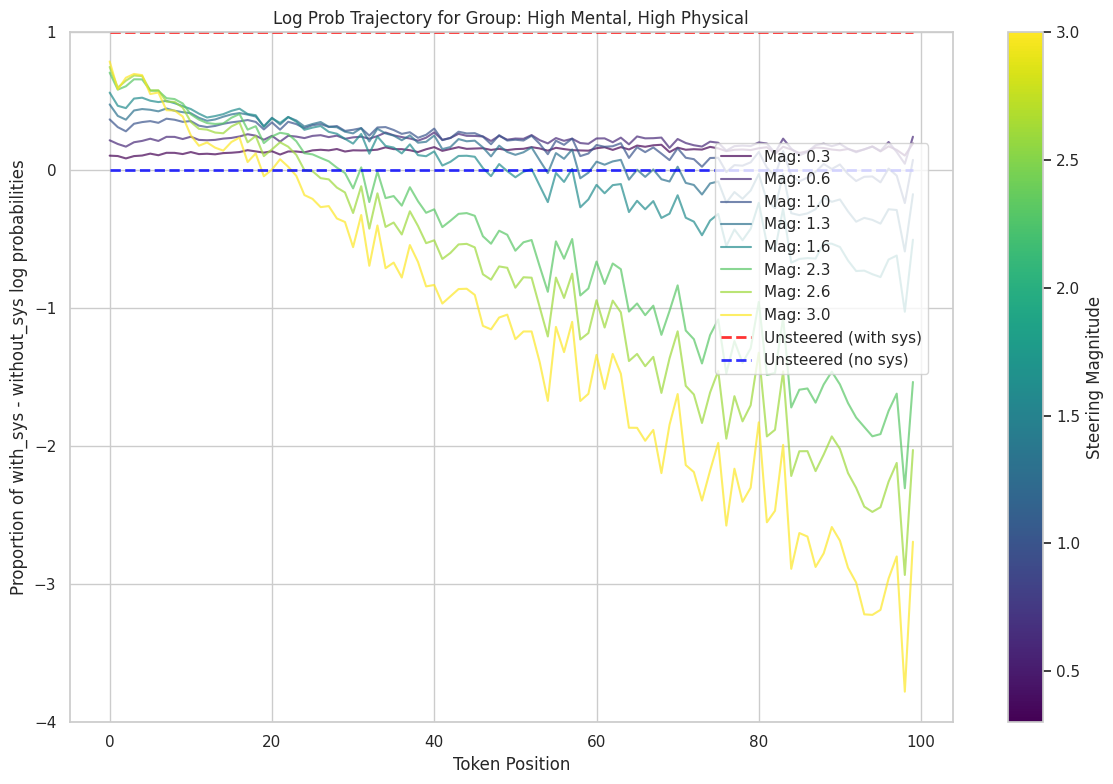

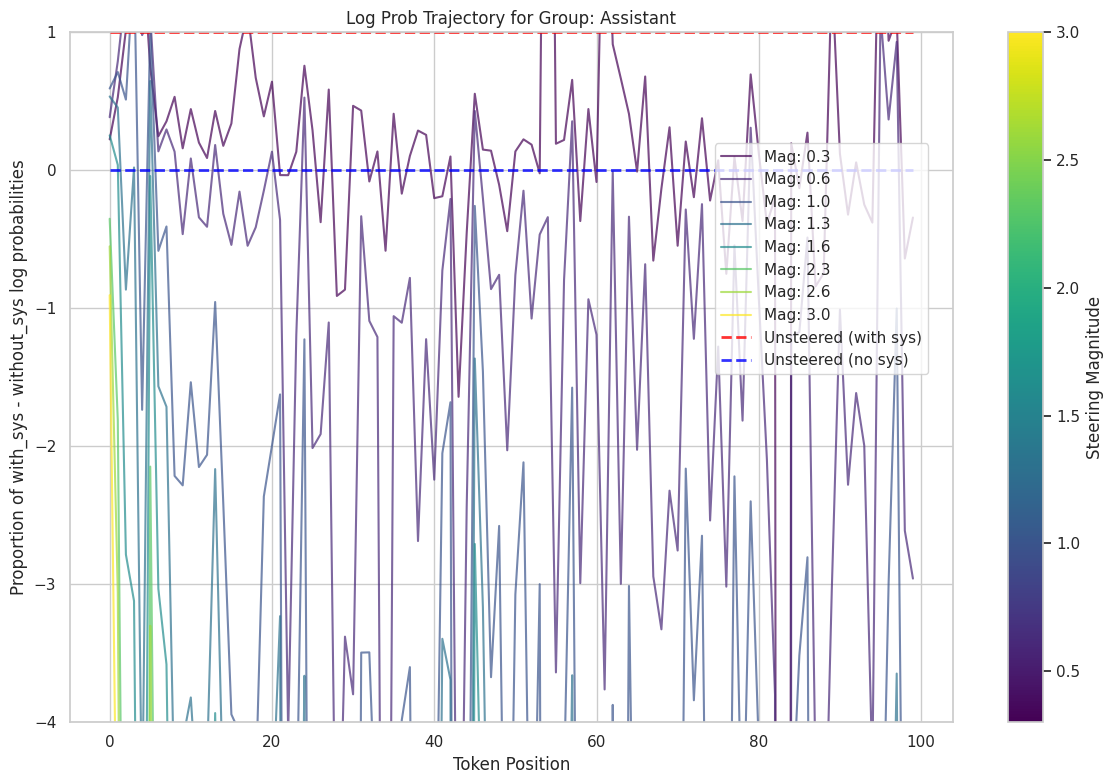

In [5]:
# Plotting Loop
df_merged = df.merge(
    words_df[['word', 'group']], 
    left_on='role_name', 
    right_on='word', 
    how='left'
)

for group in df_merged['group'].unique():
    trace_plot(df_merged[df_merged['group'] == group], group, df_logits_sys, df_logits_no_sys)

for group in df_merged['group'].unique():
    trace_plot(df_merged[df_merged['group'] == group], group, df_logits_sys, df_logits_no_sys, normalize = True)

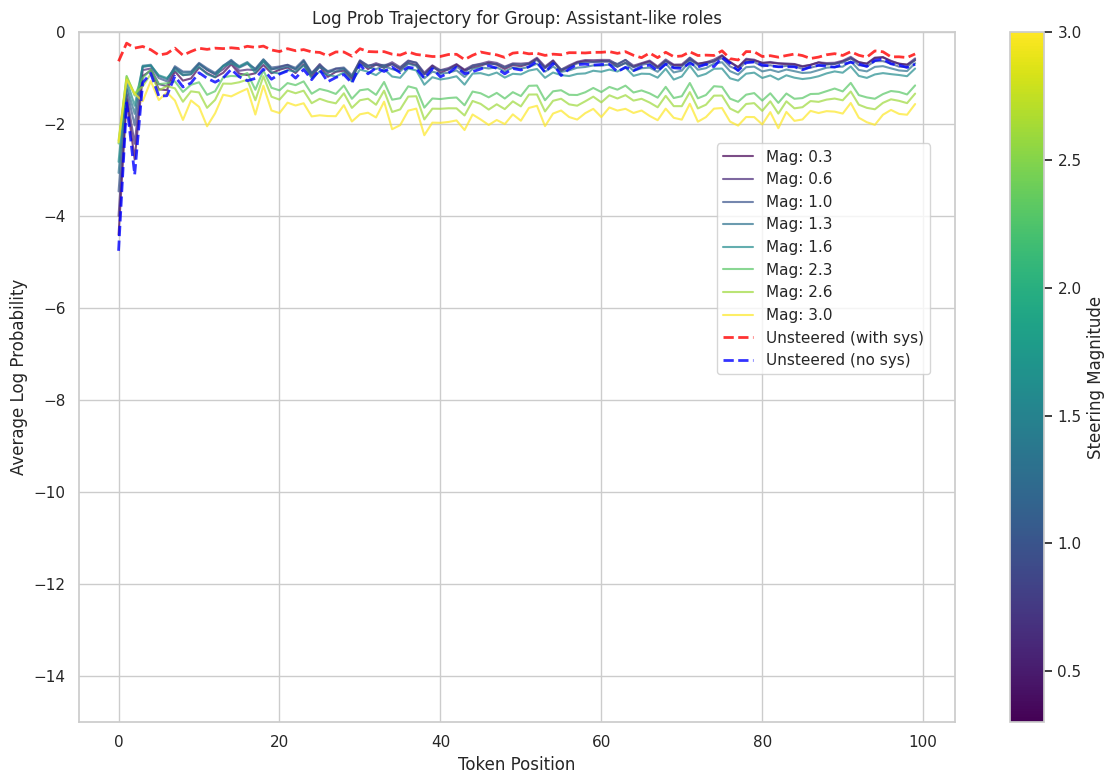

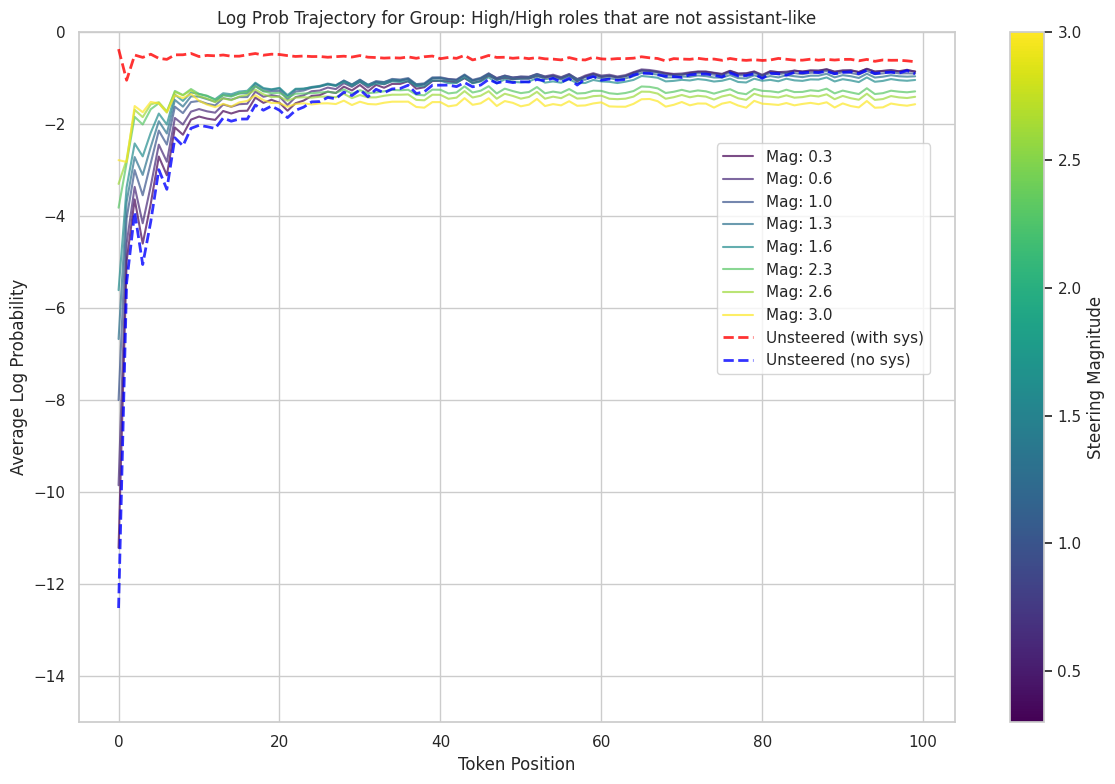

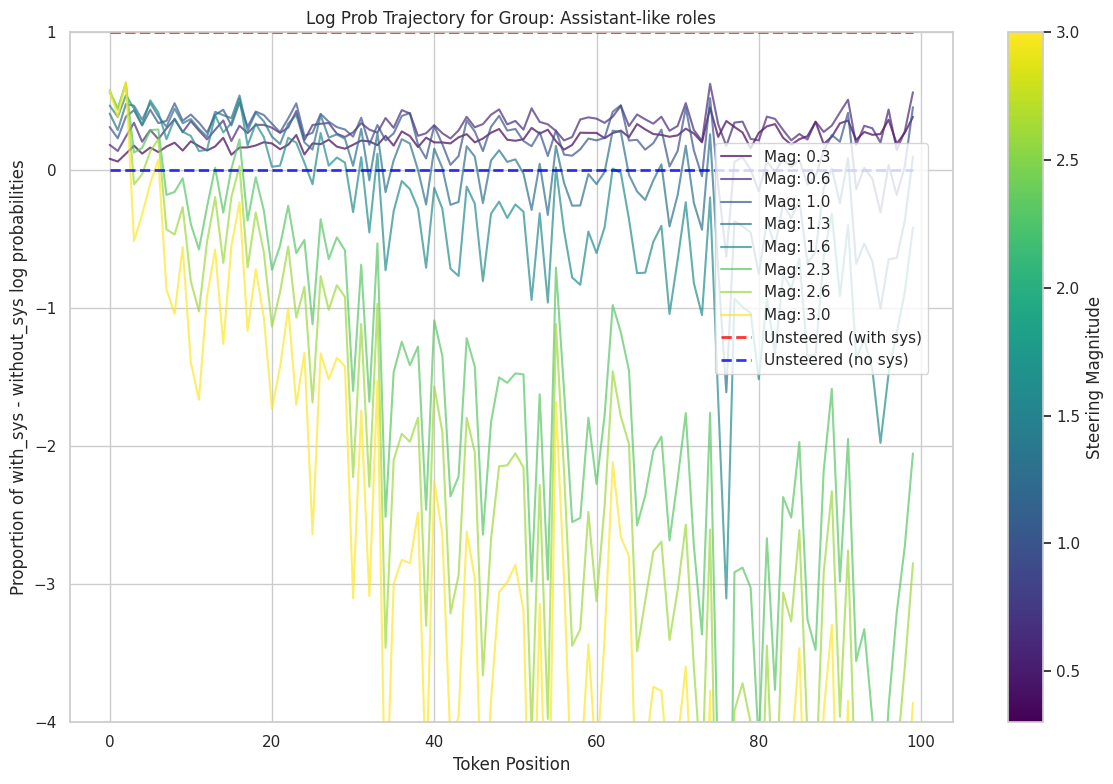

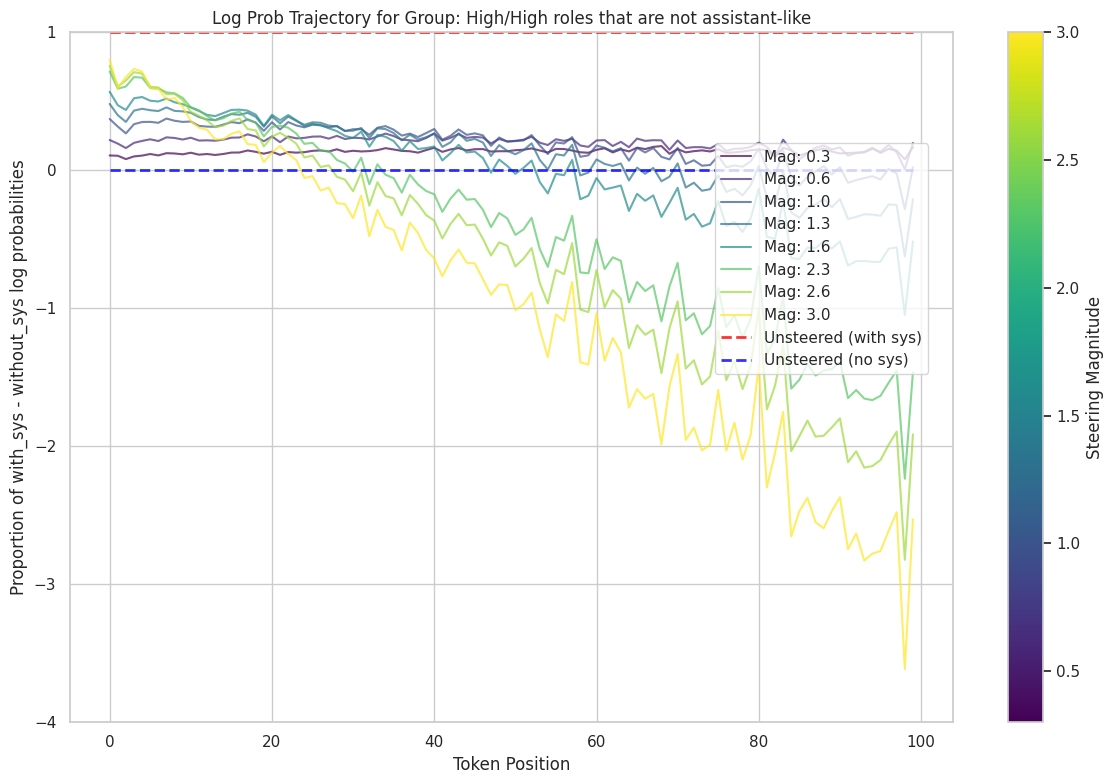

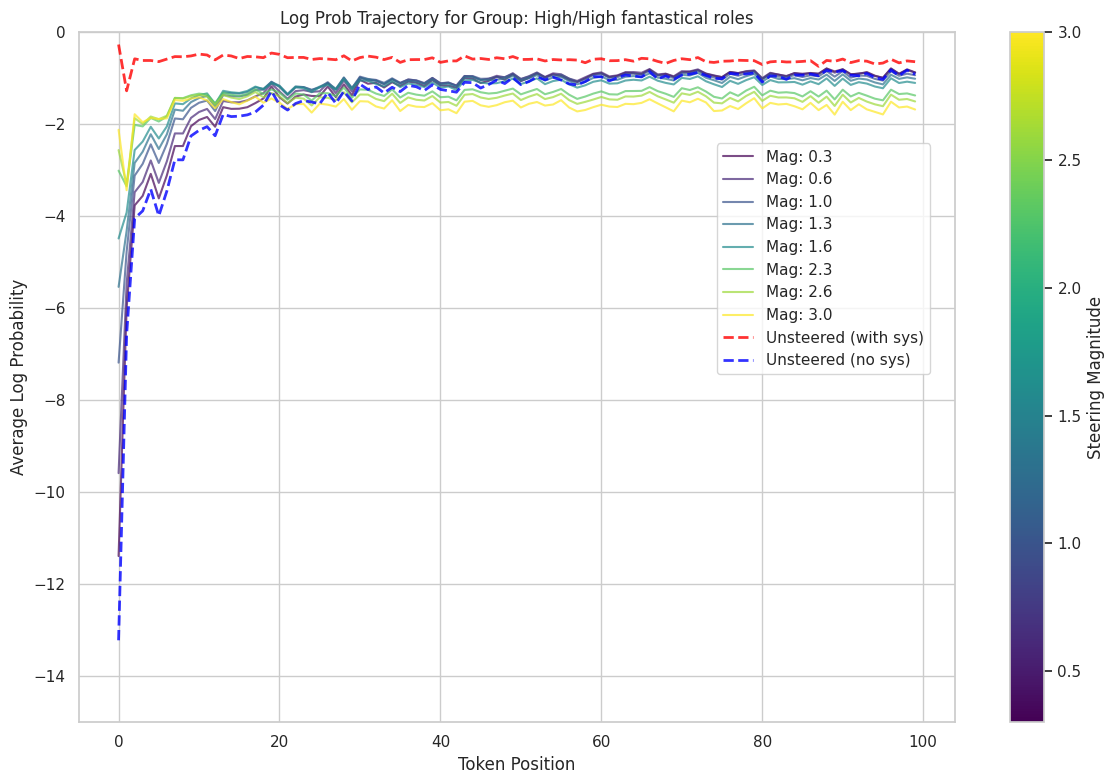

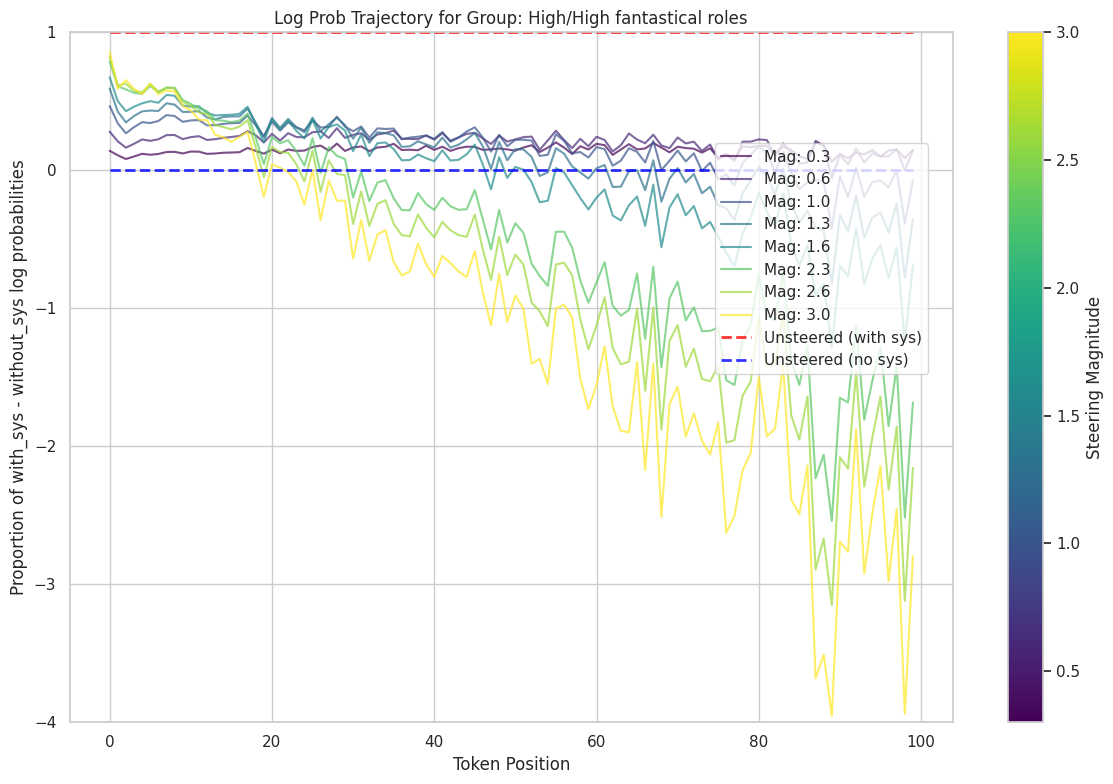

In [6]:
# assistant-like
assistant_like = ['lawyer', 'engineer', 'referee', 'professor', 'physician', 'scientist']
trace_plot(df_merged[df_merged['role_name'].isin(assistant_like)], "Assistant-like roles", df_logits_sys, df_logits_no_sys)
trace_plot(df_merged[(~df_merged['role_name'].isin(assistant_like)) & (df_merged['group']=="High Mental, High Physical")], "High/High roles that are not assistant-like", df_logits_sys, df_logits_no_sys)
trace_plot(df_merged[df_merged['role_name'].isin(assistant_like)], "Assistant-like roles", df_logits_sys, df_logits_no_sys, normalize=True)
trace_plot(df_merged[(~df_merged['role_name'].isin(assistant_like)) & (df_merged['group']=="High Mental, High Physical")], "High/High roles that are not assistant-like", df_logits_sys, df_logits_no_sys, normalize=True)


#fantastical
fantastical_roles = ['angel', 'demon', 'dragon', 'elf', 'fairy', 'giant', 'goddess', 'mermaid', 'soul', 'unicorn']
trace_plot(df_merged[df_merged['role_name'].isin(fantastical_roles)], "High/High fantastical roles", df_logits_sys, df_logits_no_sys)
trace_plot(df_merged[df_merged['role_name'].isin(fantastical_roles)], "High/High fantastical roles", df_logits_sys, df_logits_no_sys, normalize=True)


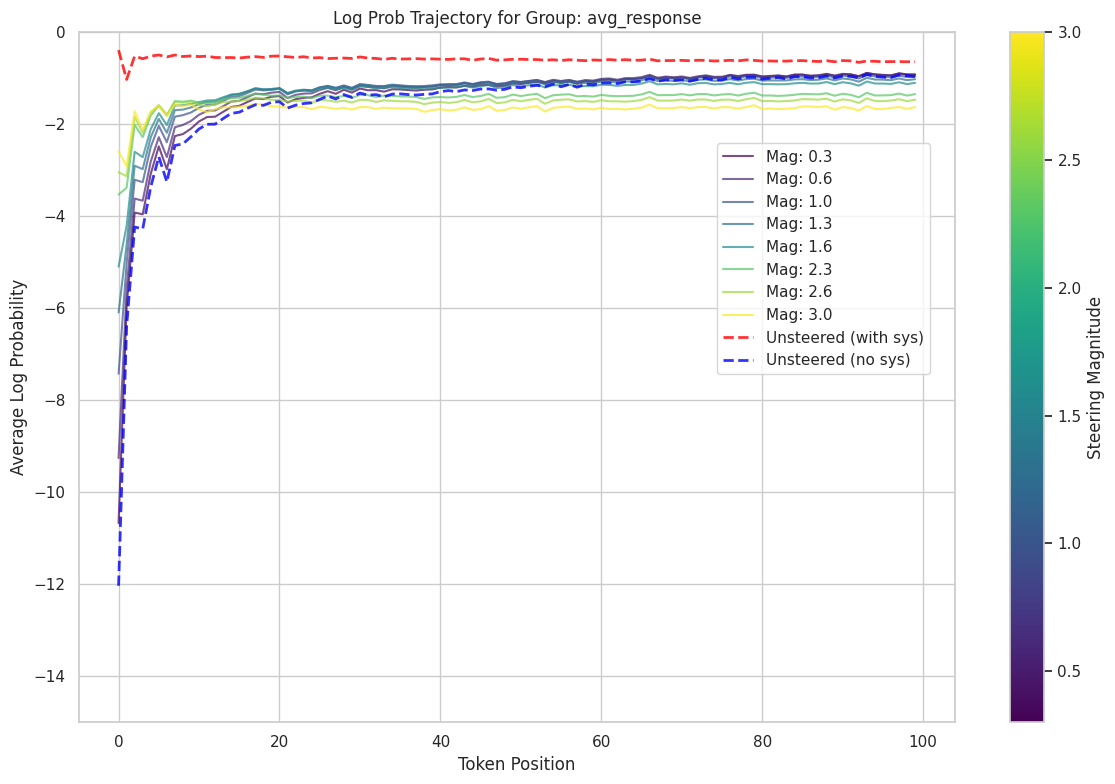

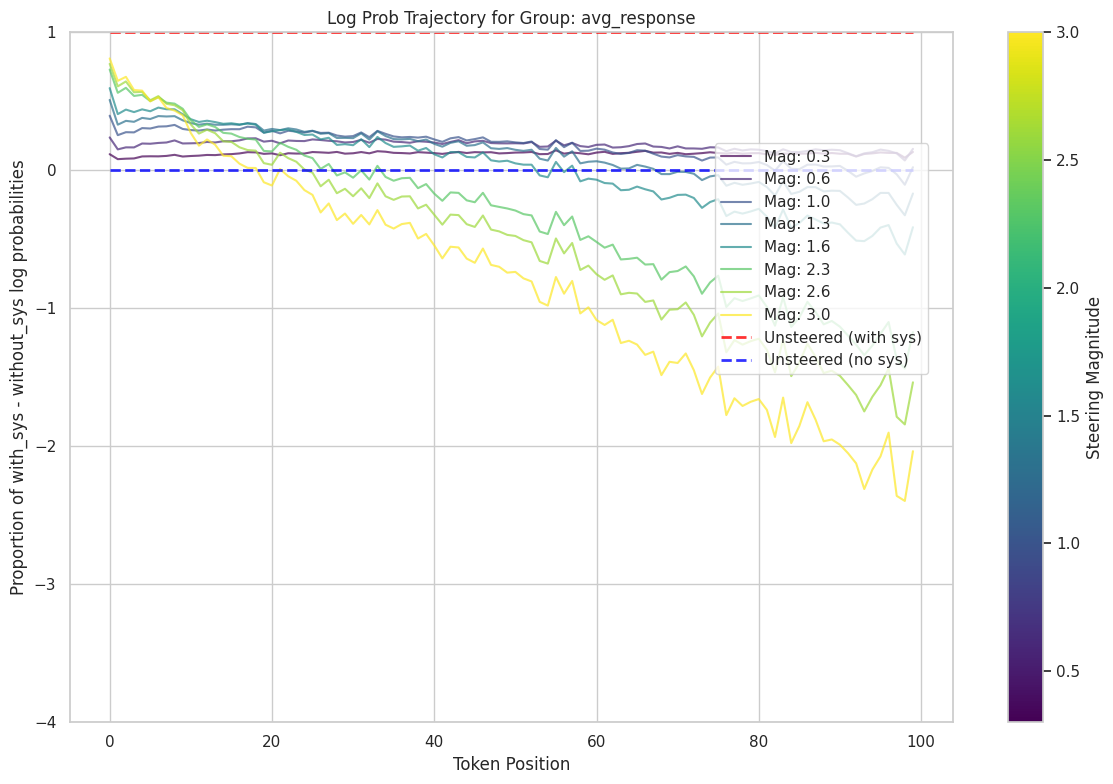

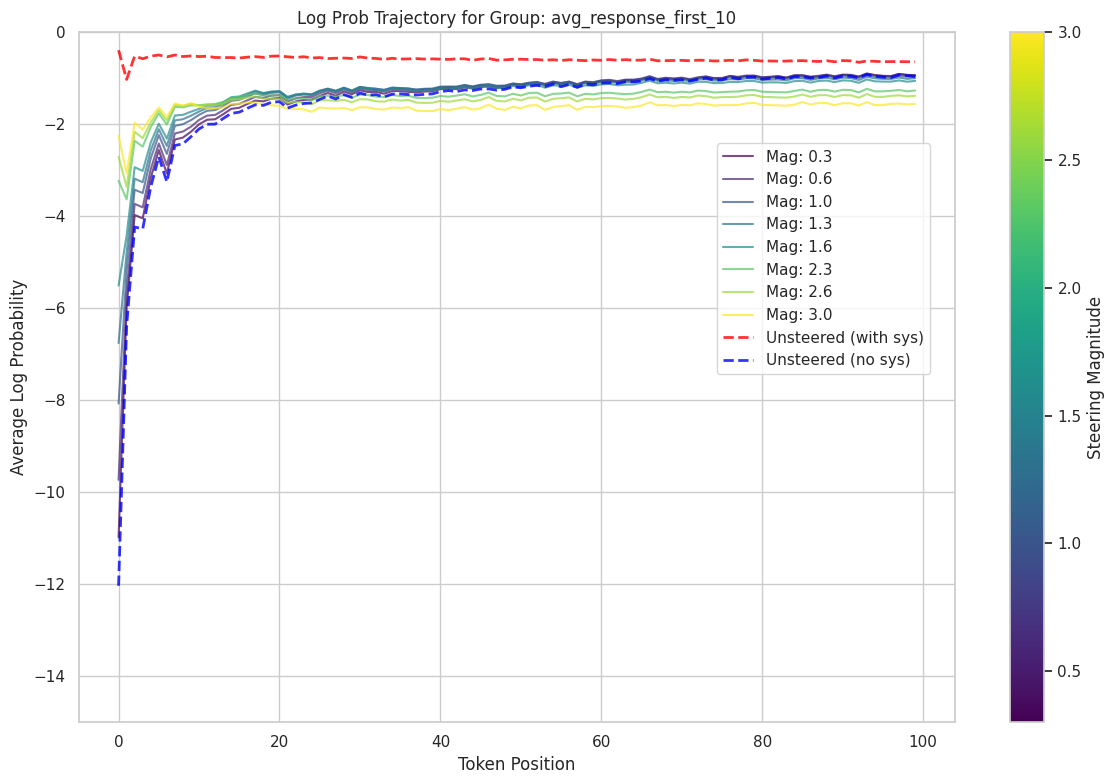

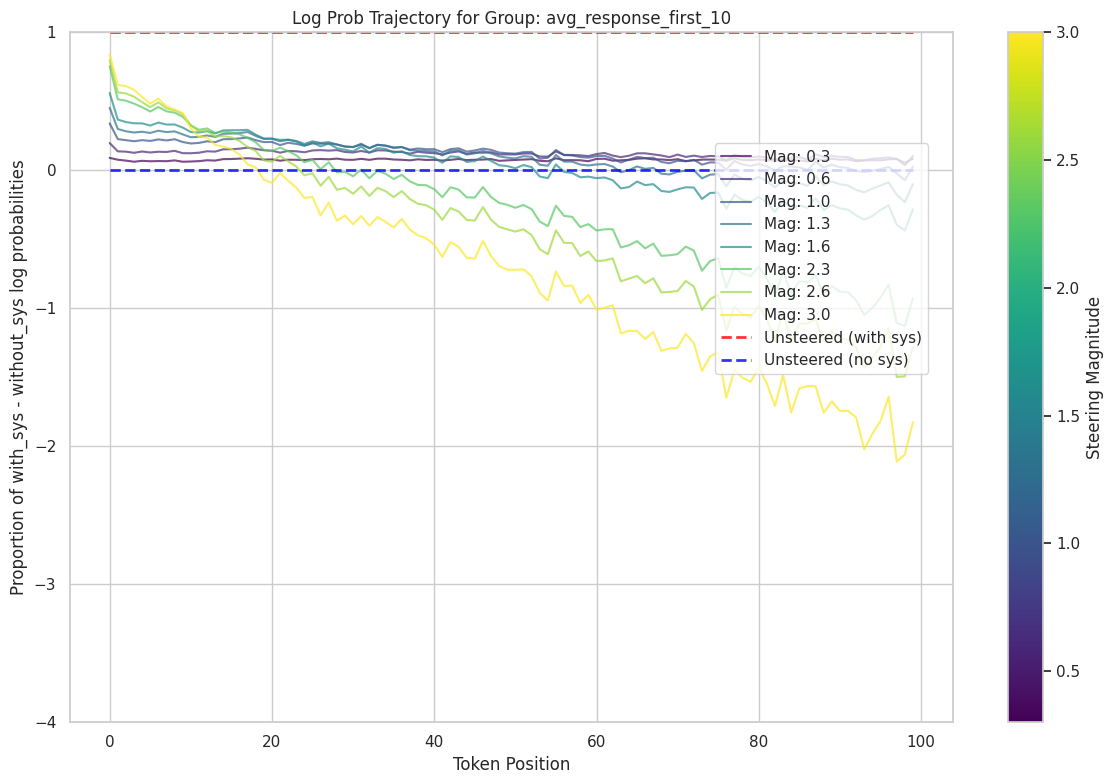

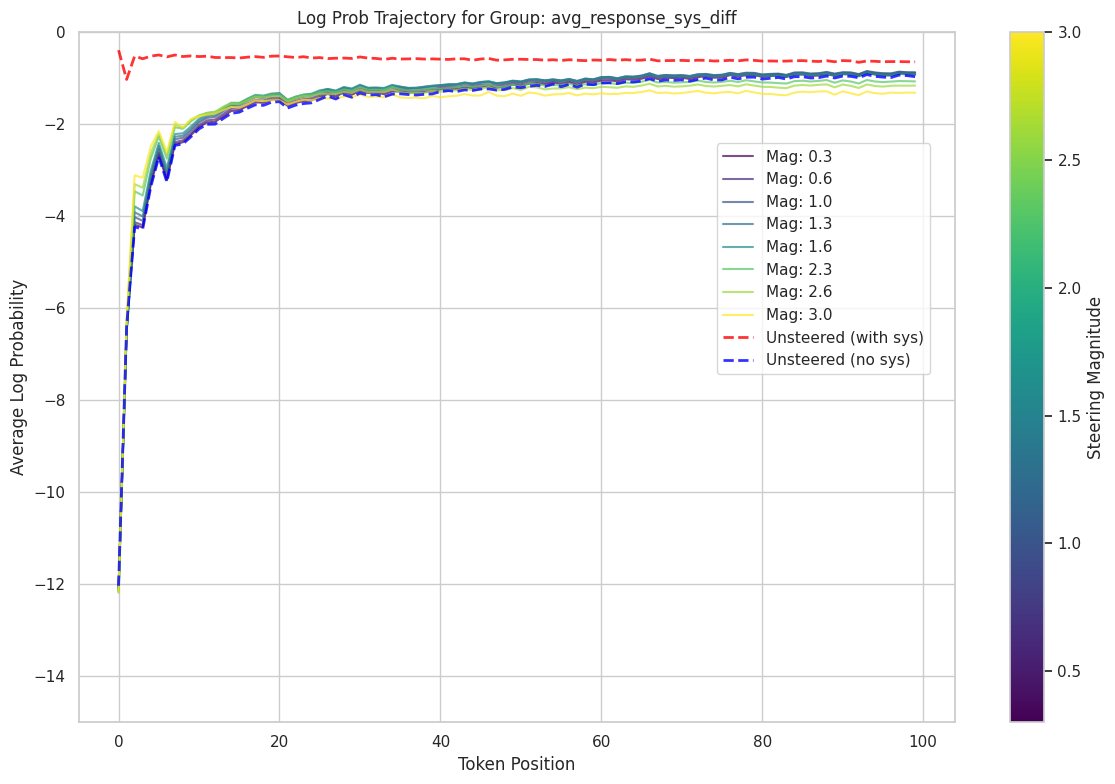

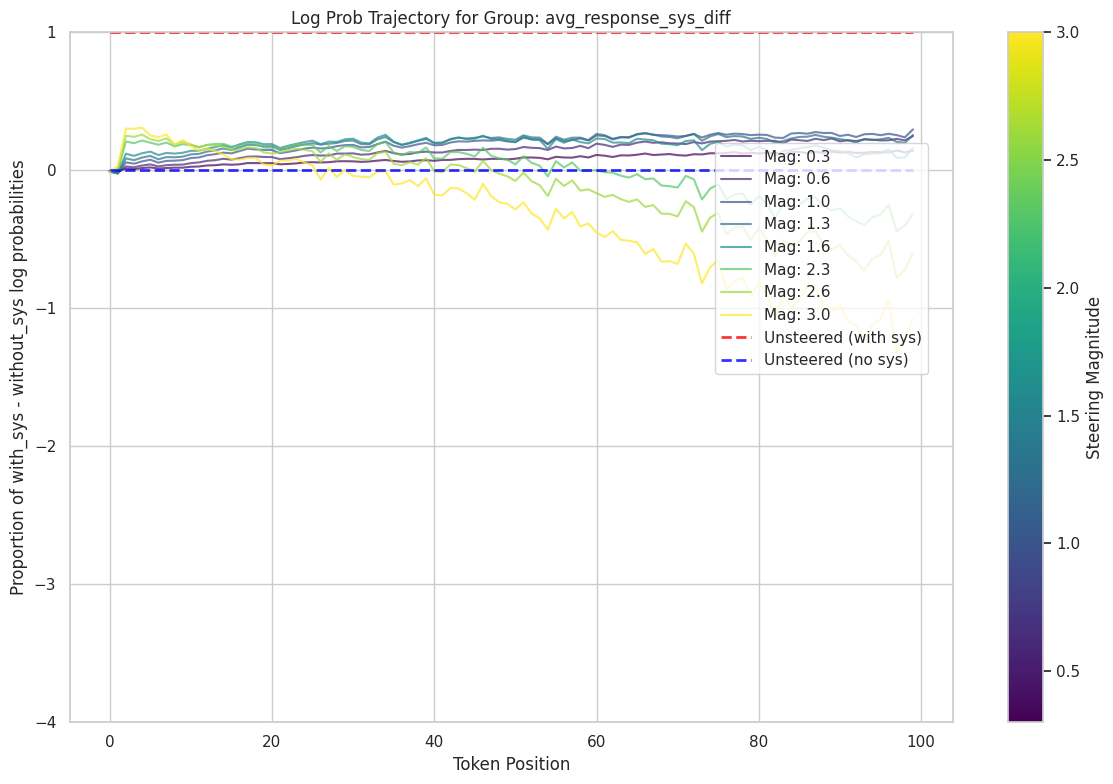

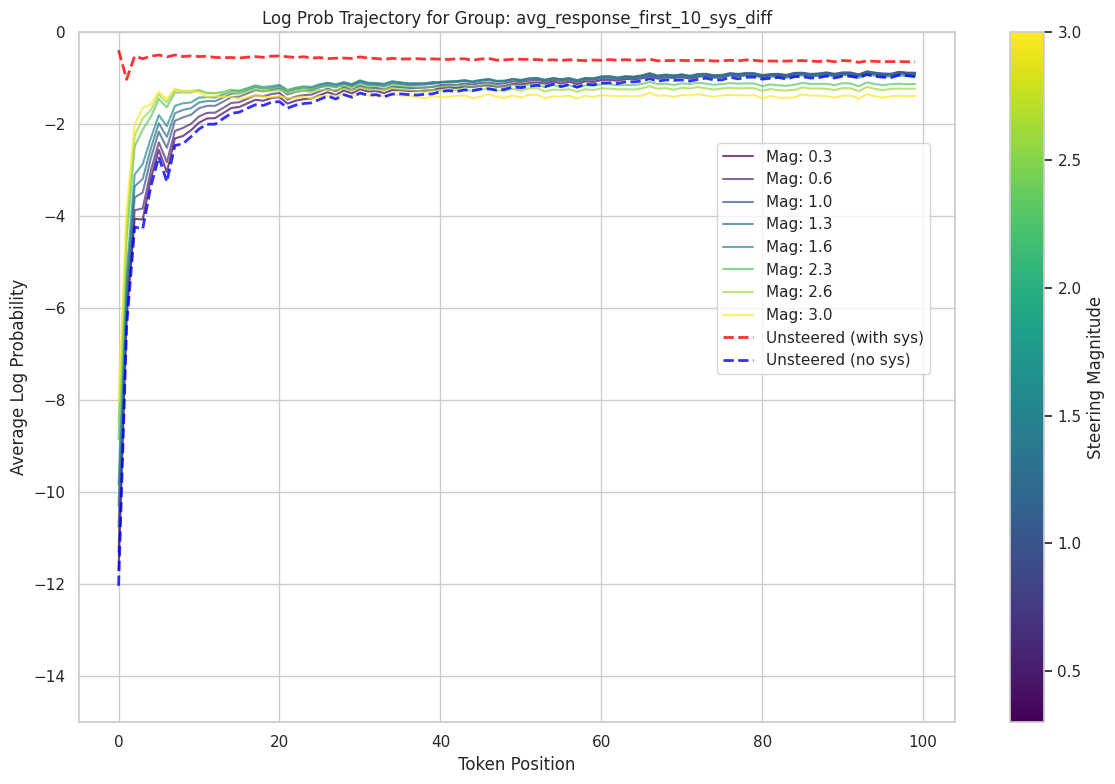

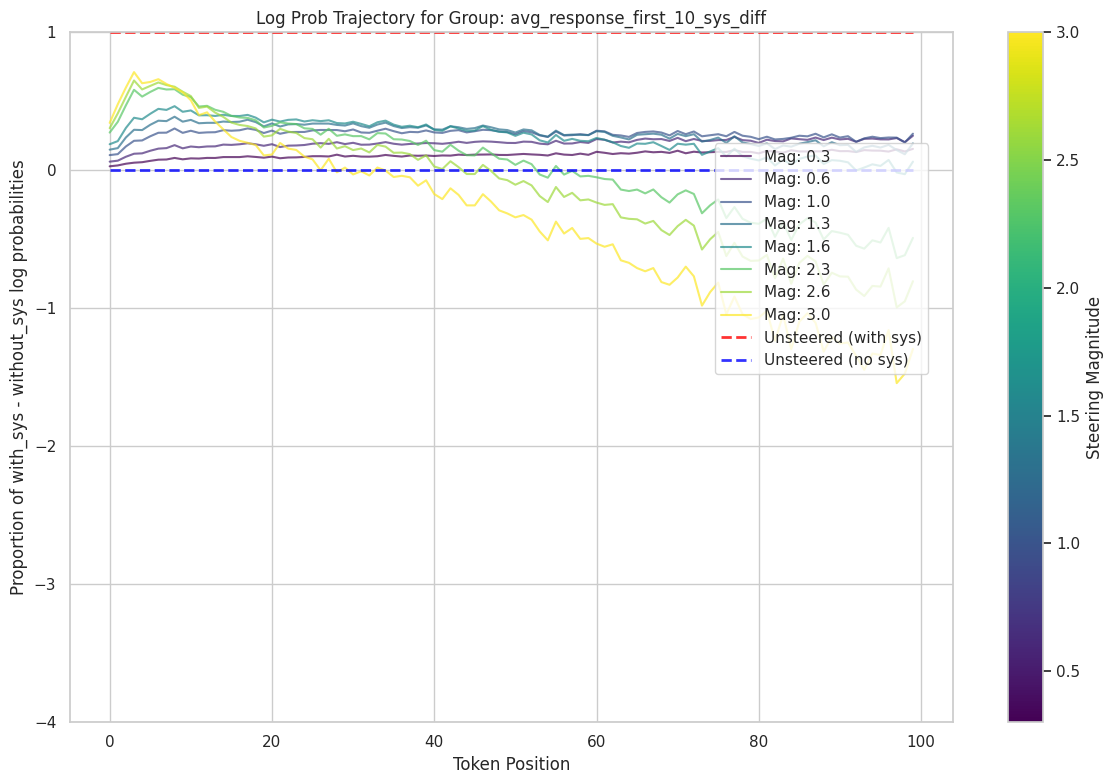

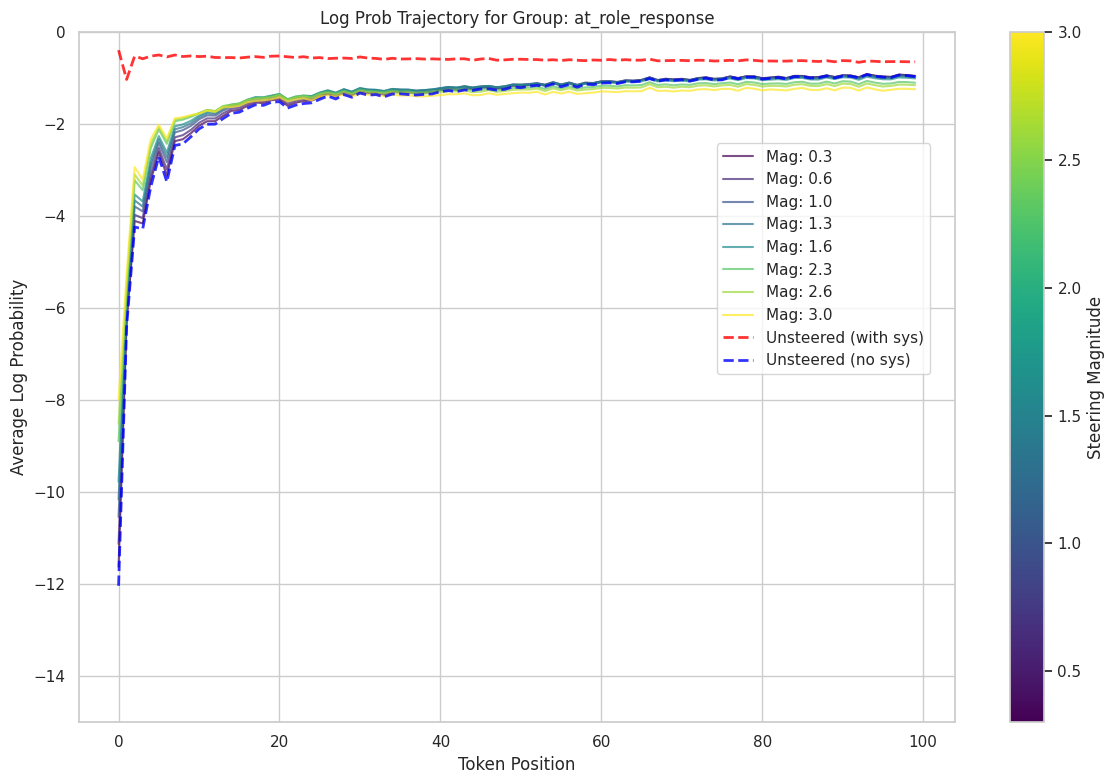

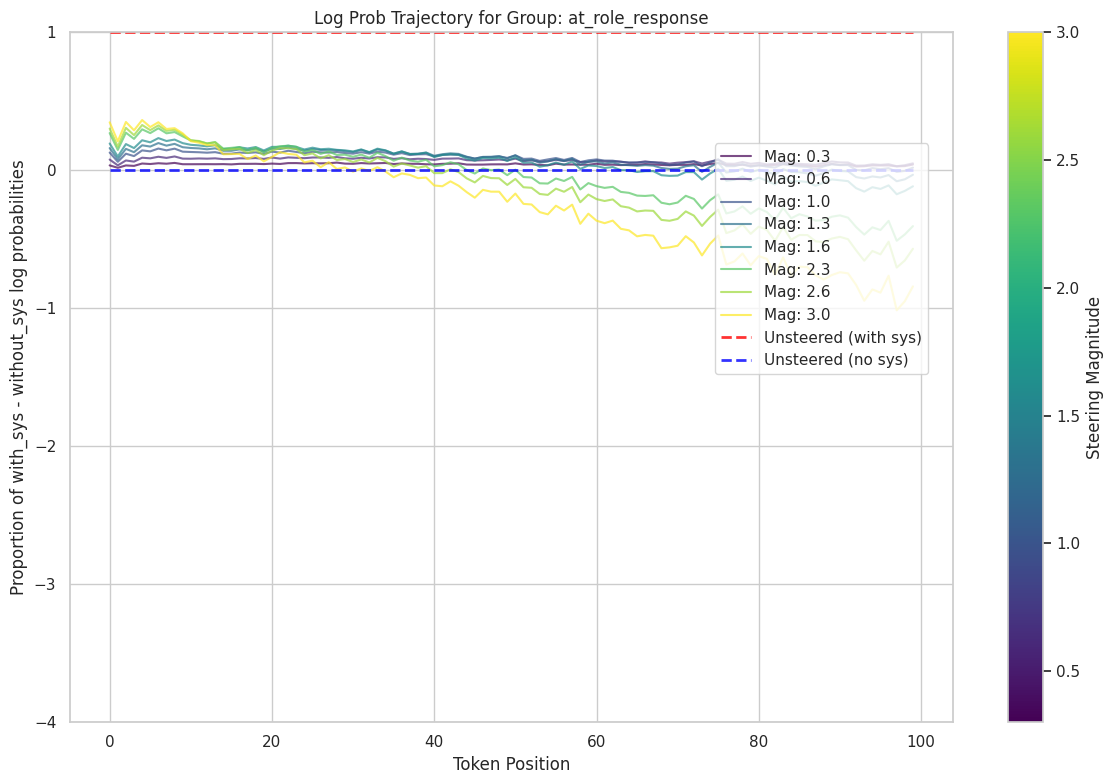

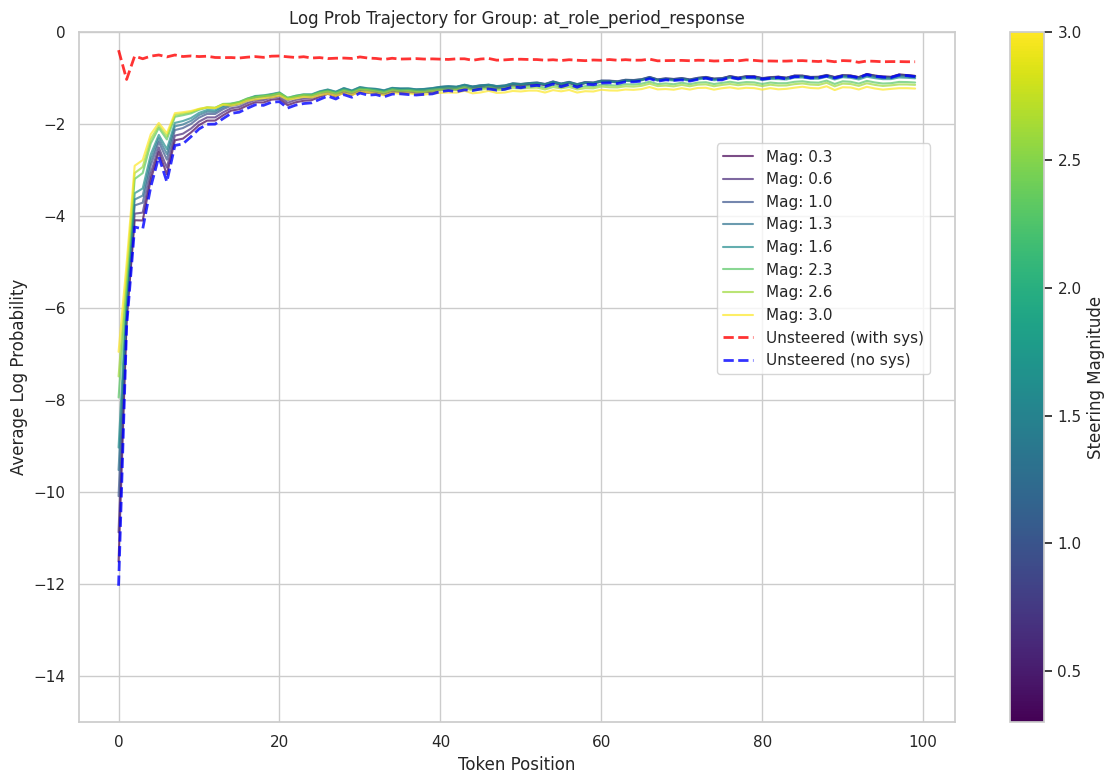

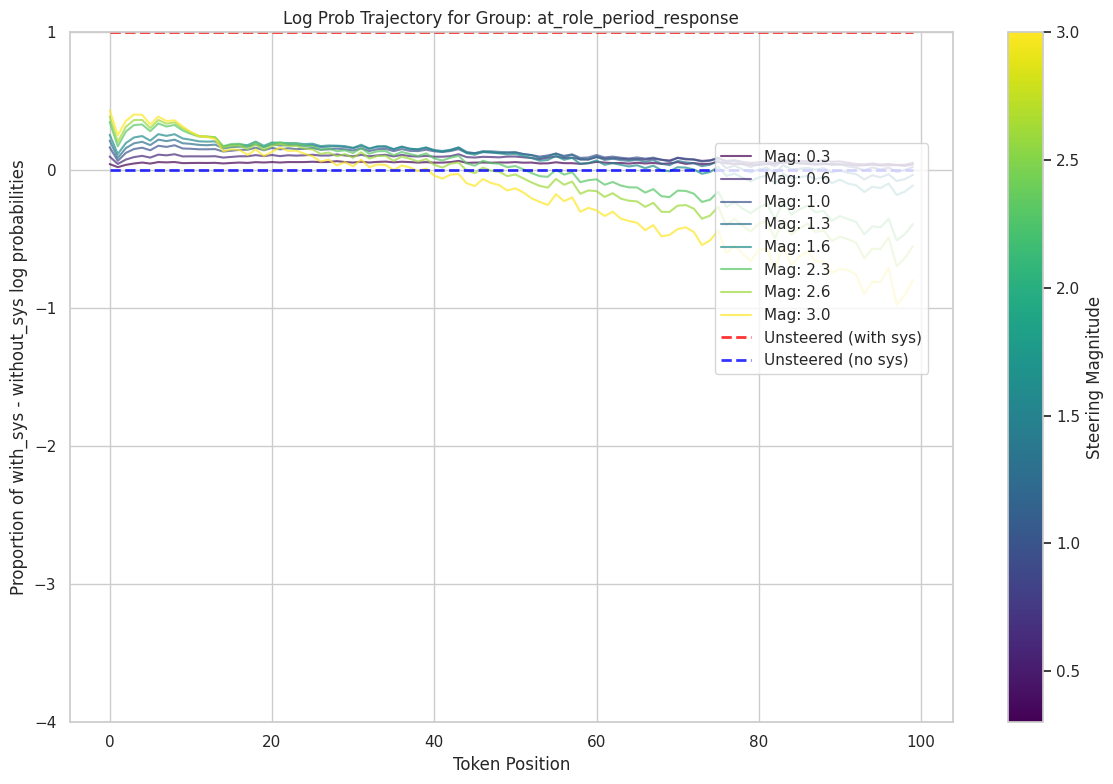

In [7]:
for file in ALL_FILES:
    
    file_df = pd.read_csv(DATA_FOLDER + file)
    file_df['first_100_response_log_probs'] = file_df['first_100_response_log_probs'].apply(parse_list)

    trace_plot(file_df, file.strip(".csv"), df_logits_sys, df_logits_no_sys)
    trace_plot(file_df, file.strip(".csv"), df_logits_sys, df_logits_no_sys, normalize=True)

# Word guess results

In [8]:
WG_FOLDER = '../data/Qwen3-30B-A3B-Instruct-2507/word_guess_steered/'

Plotted avg_response.csv: 9 magnitude conditions
Plotted avg_response_first_10.csv: 9 magnitude conditions
Plotted avg_response_sys_diff.csv: 9 magnitude conditions
Plotted avg_response_first_10_sys_diff.csv: 9 magnitude conditions
Plotted at_role_response.csv: 9 magnitude conditions
Plotted at_role_period_response.csv: 9 magnitude conditions


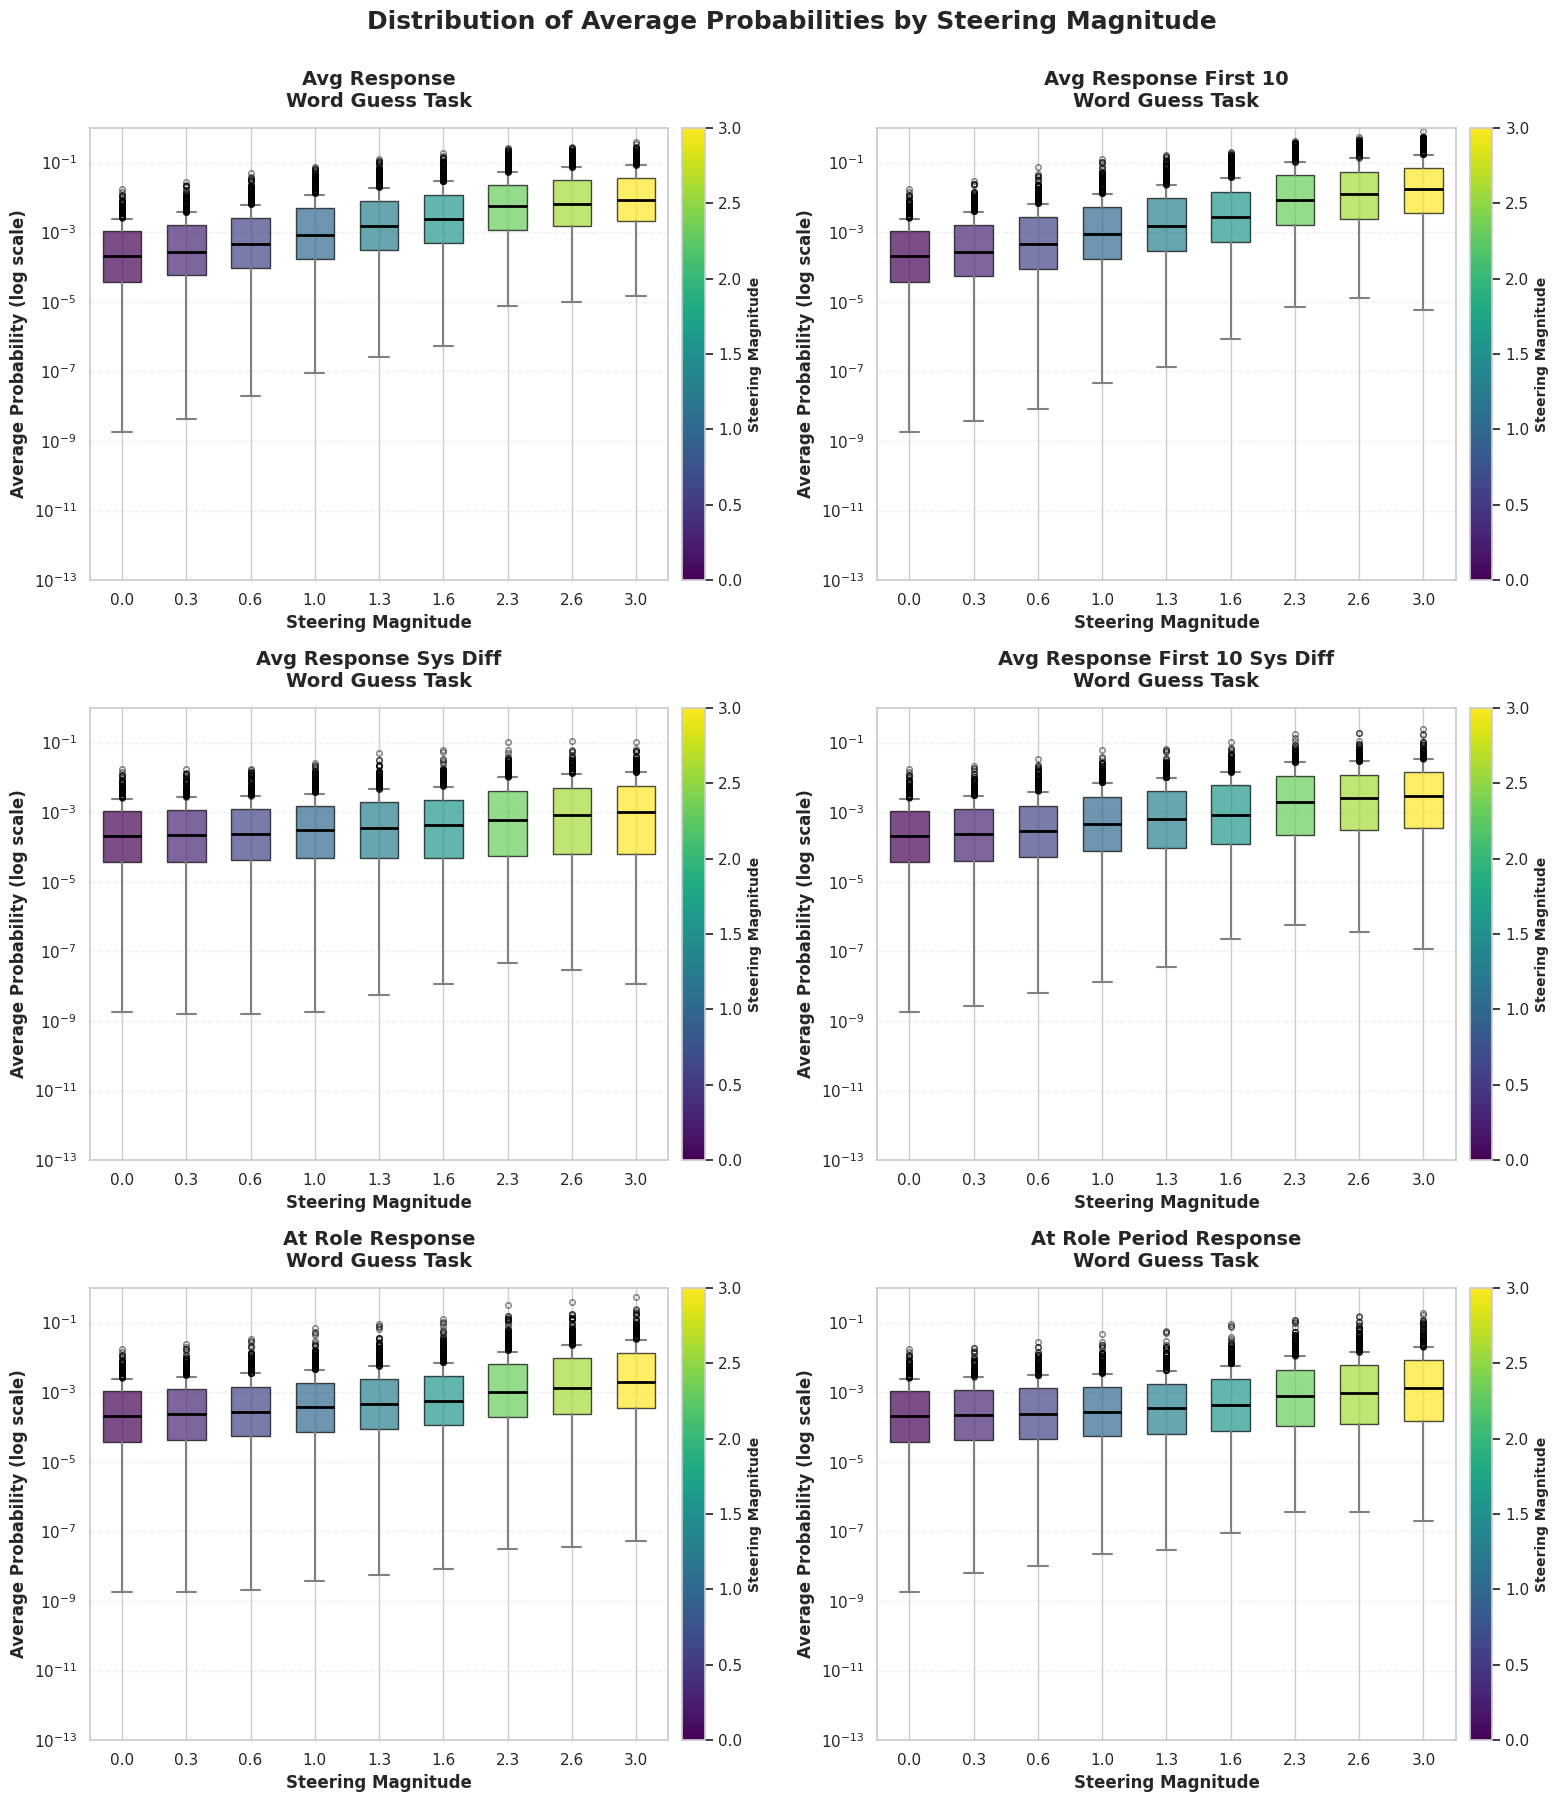

In [9]:
# Create boxplot of average log probabilities by steering magnitude for each file
# Determine how many files exist
existing_files = [f for f in ALL_FILES if os.path.exists(WG_FOLDER + f)]
n_files = len(existing_files)
task_names = ["think_of_word", "give_noun", "steering_guess", "steering_introspection"]

if n_files == 0:
    print("No files found in the data folder")
else:
    # Create subplots - 2 columns, as many rows as needed
    n_cols = 2
    n_rows = (n_files + 1) // 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 6 * n_rows))
    
    # Flatten axes array for easier iteration
    if n_rows == 1 and n_cols == 2:
        axes = axes.flatten()
    elif n_files == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, file in enumerate(existing_files):
        ax = axes[idx]
        file_path = WG_FOLDER + file
        
        # Load and parse data
        file_df = pd.read_csv(file_path)
        file_df = file_df.loc[~file_df["role_name"].isin([['AI assistant', 'helpful assistant', 'AI', 'assistant', 'llm']])]
        
        # Get unique magnitudes and sort them
        magnitudes = sorted(file_df['steering_magnitude'].unique())
        
        # Prepare boxplot data for this file
        boxplot_data = []
        magnitude_labels = []
        
        for mag in magnitudes:
            mag_df = file_df[file_df['steering_magnitude'] == mag]
            avg_log_probs = mag_df['average_log_probs'].values
            
            # Filter out any NaN values
            avg_log_probs = avg_log_probs[~np.isnan(avg_log_probs)]
            
            # Convert log probabilities to probabilities
            avg_probs = np.exp(avg_log_probs)
            
            if len(avg_probs) > 0:
                boxplot_data.append(avg_probs)
                magnitude_labels.append(mag)
        
        # Create the boxplot
        bp = ax.boxplot(boxplot_data, 
                        patch_artist=True,
                        widths=0.6,
                        showfliers=True,
                        flierprops=dict(marker='o', markersize=4, alpha=0.5))
        
        # Color boxes with viridis colormap
        if len(magnitude_labels) > 0:
            norm = mcolors.Normalize(vmin=min(magnitude_labels), vmax=max(magnitude_labels))
            cmap = cm.viridis
            
            for patch, mag in zip(bp['boxes'], magnitude_labels):
                patch.set_facecolor(cmap(norm(mag)))
                patch.set_alpha(0.7)
            
            # Style the median lines
            for median in bp['medians']:
                median.set_color('black')
                median.set_linewidth(2)
            
            # Style whiskers and caps
            for whisker in bp['whiskers']:
                whisker.set_color('gray')
                whisker.set_linewidth(1.5)
            
            for cap in bp['caps']:
                cap.set_color('gray')
                cap.set_linewidth(1.5)
        
        # Set x-axis labels with magnitudes
        ax.set_xticks(range(1, len(magnitude_labels) + 1))
        ax.set_xticklabels([f'{mag:.1f}' for mag in magnitude_labels], rotation=0)
        
        # Set y-axis to log scale
        ax.set_yscale('log')
        ax.set_ylim([10e-14, 1])
        
        # Add labels and title
        ax.set_xlabel('Steering Magnitude', fontsize=12, fontweight='bold')
        ax.set_ylabel('Average Probability (log scale)', fontsize=12, fontweight='bold')
        
        # Clean up file name for title
        file_title = file.replace('.csv', '').replace('_', ' ').title()
        ax.set_title(f'{file_title}\nWord Guess Task', 
                     fontsize=14, fontweight='bold', pad=15)
        
        # Add grid for better readability
        ax.yaxis.grid(True, linestyle='--', alpha=0.3, which='both')
        ax.set_axisbelow(True)
        
        # Add colorbar
        if len(magnitude_labels) > 0:
            sm = cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=ax, pad=0.02)
            cbar.set_label('Steering Magnitude', fontsize=10, fontweight='bold')
        
        print(f"Plotted {file}: {len(magnitude_labels)} magnitude conditions")
    
    # Hide any unused subplots
    for idx in range(n_files, len(axes)):
        axes[idx].set_visible(False)
    
    # Add overall title
    fig.suptitle('Distribution of Average Probabilities by Steering Magnitude', 
                 fontsize=18, fontweight='bold', y=1.00)
    
    # Improve overall appearance
    plt.tight_layout()
    plt.show()

# LMER modeling

In [10]:
def run_lmer_analysis(df_merged, output_column='average_log_probs', 
                      output_dir='plots', reference_group='High Mental, High Physical',
                     model_tasks = True):
    """
    Run linear mixed effects model analysis on steering data.
    
    Parameters:
    -----------
    df_merged : pd.DataFrame
        Dataframe with columns: output_column, steering_magnitude, group, role_name, task_name
    output_column : str
        Name of the dependent variable column (default: 'average_log_probs')
    output_dir : str
        Directory to save plots (default: 'plots')
    reference_group : str
        Reference category for group variable (default: 'High Mental, High Physical')
    
    Returns:
    --------
    result : statsmodels MixedLMResults object or None if fitting failed
    """
    
    import statsmodels.formula.api as smf
    from scipy import stats
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import matplotlib.cm as cm
    
    # Ensure output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # ----------------------------------------------------------------------------
    # 1. PREPARE DATA
    # ----------------------------------------------------------------------------
    
    # Filter out Assistant group
    df_work = df_merged.loc[~(df_merged['group'] == "Assistant")].copy()
    
    print("=== DATA SUMMARY ===")
    print(f"Total rows: {len(df_work)}")
    print(f"Rows with group: {df_work['group'].notna().sum()}")
    print(f"Unique words: {df_work['role_name'].nunique()}")
    print(f"Unique tasks: {df_work['task_name'].nunique()}")
    
    # Set reference category
    all_groups = df_work['group'].dropna().unique()
    # Put reference group first, then others
    group_order = [reference_group] + [g for g in sorted(all_groups) if g != reference_group]
    df_work['group'] = pd.Categorical(
        df_work['group'],
        categories=group_order,
        ordered=False
    )
    
    # Clean data for modeling
    df_model = df_work[[output_column, 'steering_magnitude',
                         'group', 'role_name', 'task_name']].dropna().copy()
    
    print("\n=== GROUP DISTRIBUTION ===")
    group_summary = df_model.groupby('group').agg({
        'role_name': 'nunique',
        output_column: ['count', 'mean', 'std']
    })
    group_summary.columns = ['n_words', 'n_obs', f'mean_{output_column}', f'std_{output_column}']
    print(group_summary.round(3))
    
    print("\n=== STEERING MAGNITUDES ===")
    print(f"Magnitudes: {sorted(df_model['steering_magnitude'].unique())}")
    print(f"Sample sizes by magnitude:")
    print(df_model.groupby('steering_magnitude').size())
    
    # ----------------------------------------------------------------------------
    # 2. FIT MIXED EFFECTS MODEL
    # ----------------------------------------------------------------------------
    
    print("\n" + "="*80)
    print("FITTING LINEAR MIXED EFFECTS MODEL")
    print("="*80)
    print(f"\nModel: {output_column} ~ steering_magnitude * C(group)")
    print("Random effects: (1 | role_name)")
    print(f"Reference group: {reference_group} (at zero steering)")
    print("-"*80)
    
    # Create model formula
    if model_tasks:
        formula = f"{output_column} ~ steering_magnitude * C(group, Treatment('{reference_group}')) + steering_magnitude * C(task_name, Treatment('{task_names[0]}'))"
    else:
        formula = f"{output_column} ~ steering_magnitude * C(group, Treatment('{reference_group}'))"

    # Create and fit model
    model = smf.mixedlm(
        formula=formula,
        data=df_model,
        groups=df_model['role_name']
    )
    
    # Fit model
    try:
        result = model.fit(method='lbfgs', maxiter=1000)
        
        print("\n### FULL MODEL SUMMARY ###\n")
        summary_obj = result.summary()
        print(summary_obj)
        
        print("\n### KEY STATISTICS ###")
        print(f"AIC: {result.aic:.2f}")
        print(f"BIC: {result.bic:.2f}")
        print(f"Log-Likelihood: {result.llf:.2f}")
        print(f"N observations: {result.nobs}")
        print(f"N groups (words): {df_model['role_name'].nunique()}")
        
        # Fixed effects with confidence intervals
        print("\n### FIXED EFFECTS ###")
        fe_summary = pd.DataFrame({
            'Coef': result.fe_params,
            'SE': result.bse_fe,
            't': result.tvalues,
            'p': result.pvalues,
            'CI_lower': result.conf_int()[0],
            'CI_upper': result.conf_int()[1]
        })
        print(fe_summary.round(4))
        
        # Random effects variance
        print("\n### RANDOM EFFECTS VARIANCE ###")
        word_var = result.cov_re.iloc[0, 0]
        resid_var = result.scale
        icc = word_var / (word_var + resid_var)
        print(f"Word-level variance: {word_var:.4f}")
        print(f"Residual variance: {resid_var:.4f}")
        print(f"ICC: {icc:.4f} ({icc*100:.1f}% of variance is between words)")
        
    except Exception as e:
        print(f"\n### ERROR: Model fitting failed ###")
        print(f"Error: {e}")
        print("\nTroubleshooting:")
        print("1. Check for collinearity in predictors")
        print("2. Verify sufficient observations per group")
        print("3. Try different optimization methods")
        return None
    
    # ----------------------------------------------------------------------------
    # 3. VISUALIZATIONS
    # ----------------------------------------------------------------------------
    
    # Add fitted values and residuals
    df_model['fitted'] = result.fittedvalues
    df_model['residuals'] = result.resid
    
    # Create 6-panel figure
    fig = plt.figure(figsize=(16, 10))
    
    # --- Plot 1: Coefficient plot with error bars ---
    ax1 = plt.subplot(2, 3, 1)
    print(fe_summary['Coef'].tolist())
    fe_plot = fe_summary.loc[~fe_summary.index.isin(['Group Var', 'Intercept']) ]  # Exclude intercept
    y_pos = np.arange(len(fe_plot))
    ax1.barh(y_pos, fe_plot['Coef'], xerr=fe_plot['SE'],
             color='steelblue', alpha=0.7, capsize=5)
    ax1.axvline(x=0, color='red', linestyle='--', linewidth=1)
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels([idx.replace(f"C(group, Treatment('{reference_group}'))[T.", "").replace("]", "").replace("steering_magnitude:", "steer×")
                          for idx in fe_plot.index], fontsize=8)
    ax1.set_xlabel('Coefficient Estimate', fontweight='bold')
    ax1.set_title('Fixed Effects Estimates ± SE', fontweight='bold', fontsize=12)
    ax1.grid(axis='x', alpha=0.3)
    
    # --- Plot 2: Confidence intervals ---
    ax2 = plt.subplot(2, 3, 2)
    for i, (idx, row) in enumerate(fe_plot.iterrows()):
        # Color based on significance
        color = 'darkred' if (row['CI_lower'] > 0 or row['CI_upper'] < 0) else 'steelblue'
        ax2.plot([row['CI_lower'], row['CI_upper']], [i, i], 'o-',
                color=color, linewidth=2, markersize=6)
    ax2.axvline(x=0, color='red', linestyle='--', linewidth=1)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([idx.replace(f"C(group, Treatment('{reference_group}'))[T.", "").replace("]", "").replace("steering_magnitude:", "steer×")
                          for idx in fe_plot.index], fontsize=8)
    ax2.set_xlabel('95% Confidence Interval', fontweight='bold')
    ax2.set_title('Fixed Effects 95% CI', fontweight='bold', fontsize=12)
    ax2.grid(axis='x', alpha=0.3)
    
    # --- Plot 3: Interaction plot ---
    ax3 = plt.subplot(2, 3, 3)
    steering_range = np.linspace(df_model['steering_magnitude'].min(),
                                 df_model['steering_magnitude'].max(), 50)
    intercept = result.fe_params['Intercept']
    steering_coef = result.fe_params['steering_magnitude']
    
    # Plot reference group
    y_ref = intercept + steering_coef * steering_range
    ax3.plot(steering_range, y_ref, linewidth=2.5, label=reference_group, color='black')
    
    # Plot other groups
    colors = ['blue', 'green', 'red', 'orange', 'purple']
    for i, group in enumerate(df_model['group'].cat.categories[1:]):
        group_coef = result.fe_params.get(f"C(group, Treatment('{reference_group}'))[T.{group}]", 0)
        int_coef = result.fe_params.get(
            f"steering_magnitude:C(group, Treatment('{reference_group}'))[T.{group}]", 0)
        y_group = intercept + group_coef + (steering_coef + int_coef) * steering_range
        ax3.plot(steering_range, y_group, linewidth=2, label=group, color=colors[i % len(colors)])
    
    ax3.set_xlabel('Steering Magnitude', fontweight='bold')
    ax3.set_ylabel(f'Predicted {output_column}', fontweight='bold')
    ax3.set_title('Group × Steering Interaction', fontweight='bold', fontsize=12)
    ax3.legend(fontsize=7, loc='best')
    ax3.grid(alpha=0.3)
    
    # --- Plot 4: Residuals vs Fitted ---
    ax4 = plt.subplot(2, 3, 4)
    ax4.scatter(df_model['fitted'], df_model['residuals'], alpha=0.3, s=10)
    ax4.axhline(y=0, color='red', linestyle='--', linewidth=1)
    ax4.set_xlabel('Fitted Values', fontweight='bold')
    ax4.set_ylabel('Residuals', fontweight='bold')
    ax4.set_title('Residuals vs Fitted', fontweight='bold', fontsize=12)
    ax4.grid(alpha=0.3)
    
    # --- Plot 5: Q-Q plot ---
    ax5 = plt.subplot(2, 3, 5)
    stats.probplot(df_model['residuals'], dist="norm", plot=ax5)
    ax5.set_title('Normal Q-Q Plot', fontweight='bold', fontsize=12)
    ax5.grid(alpha=0.3)
    
    # --- Plot 6: Random effects distribution ---
    ax6 = plt.subplot(2, 3, 6)
    re = result.random_effects
    re_vals = [re[k][0] for k in sorted(re.keys())]
    ax6.hist(re_vals, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
    ax6.axvline(x=0, color='red', linestyle='--', linewidth=1)
    ax6.set_xlabel('Random Intercept', fontweight='bold')
    ax6.set_ylabel('Frequency', fontweight='bold')
    ax6.set_title(f'Word-Level Random Effects (N={len(re_vals)})', fontweight='bold', fontsize=12)
    ax6.grid(alpha=0.3)
    
    plt.tight_layout()
    plot_path = os.path.join(output_dir, "lmm_analysis.png")
    plt.savefig(plot_path, dpi=300, bbox_inches="tight")
    plt.show()
    
    print("\n" + "="*80)
    print(f"Visualization saved to {plot_path}")
    print("="*80)
    
    return result

## Role Resposes

=== DATA LOADING ===
Original rows: 50000
Merged rows: 50000
Rows with group: 50000
Unique words: 125
Unique tasks: ['future_self' 'remembered']
=== DATA SUMMARY ===
Total rows: 48000
Rows with group: 48000
Unique words: 120
Unique tasks: 2

=== GROUP DISTRIBUTION ===
                            n_words  n_obs  mean_average_first_10_log_probs  \
group                                                                         
High Mental, High Physical       40  16000                           -2.475   
Low Mental, High Physical        40  16000                           -3.006   
Low Mental, Low Physical         40  16000                           -2.975   

                            std_average_first_10_log_probs  
group                                                       
High Mental, High Physical                           1.430  
Low Mental, High Physical                            1.542  
Low Mental, Low Physical                             1.493  

=== STEERING MAGNITUDES ===
M

/tmp/ipykernel_493323/919907580.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_summary = df_model.groupby('group').agg({
/home/nate/repos/animacy/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)



### FULL MODEL SUMMARY ###

                                                    Mixed Linear Model Regression Results
Model:                                   MixedLM                        Dependent Variable:                        average_first_10_log_probs
No. Observations:                        48000                          Method:                                    REML                      
No. Groups:                              120                            Scale:                                     1.3547                    
Min. group size:                         400                            Log-Likelihood:                            -75680.1692               
Max. group size:                         400                            Converged:                                 Yes                       
Mean group size:                         400.0                                                                                               
-----------------------------

/tmp/ipykernel_493323/919907580.py:229: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  re_vals = [re[k][0] for k in sorted(re.keys())]


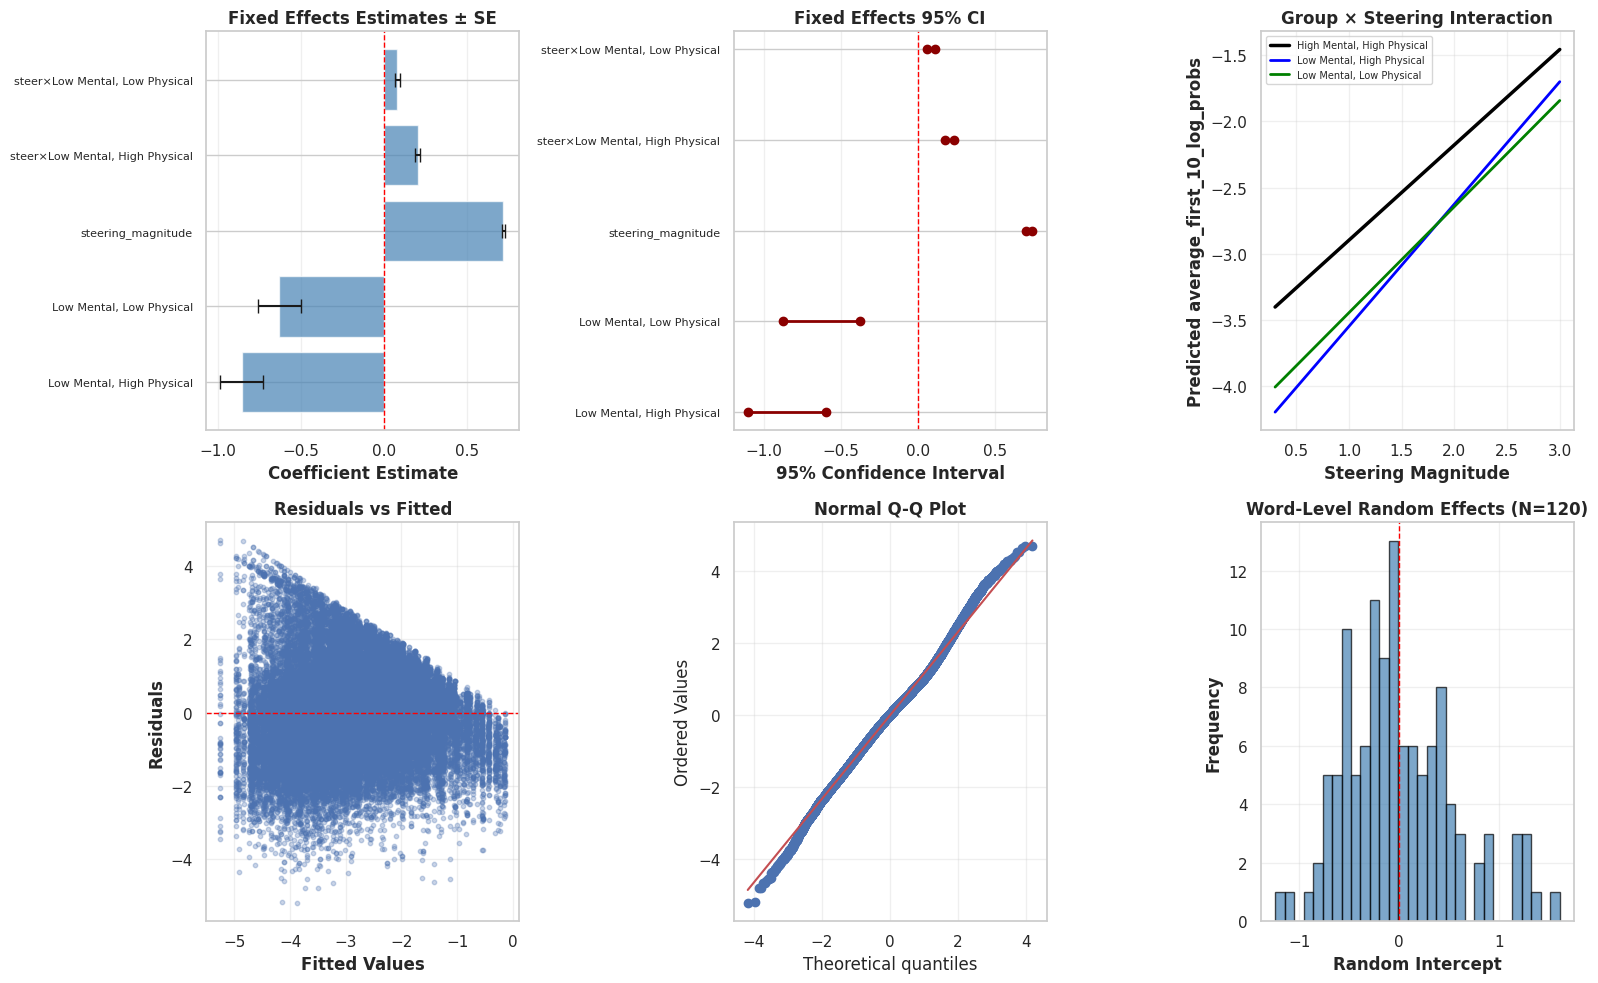


Visualization saved to plots/lmm_analysis.png


In [11]:
# ============================================================================
# Execute LMER Analysis for avg_response, average_first_10_log_probs
# ============================================================================

# Load word_guess_steered data

df = pd.read_csv(DATA_FOLDER + 'avg_response.csv')
df['average_first_10_log_probs'] = df['first_100_response_log_probs'].apply(lambda x: sum(ast.literal_eval(x)[:10]) / 10)

# Merge datasets
df_merged = df.merge(
    words_df[['word', 'group']], 
    left_on='role_name', 
    right_on='word', 
    how='left'
)


print("=== DATA LOADING ===")
print(f"Original rows: {len(df)}")
print(f"Merged rows: {len(df_merged)}")
print(f"Rows with group: {df_merged['group'].notna().sum()}")
print(f"Unique words: {df_merged['role_name'].nunique()}")
print(f"Unique tasks: {df_merged['task_name'].unique()}")

# Check for unmapped words
missing_words = df[~df['role_name'].isin(words_df['word'])]['role_name'].unique()
if len(missing_words) > 0:
    print(f"\nWARNING: Unmapped words: {missing_words}")

# Run LMER analysis
lmm_result = run_lmer_analysis(
    df_merged=df_merged,
    output_column='average_first_10_log_probs',
    output_dir=OUTPUT_DIR,
    reference_group='High Mental, High Physical',
    model_tasks = False,
)

=== DATA LOADING ===
Original rows: 50000
Merged rows: 50000
Rows with group: 50000
Unique words: 125
Unique tasks: ['future_self' 'remembered']
=== DATA SUMMARY ===
Total rows: 48000
Rows with group: 48000
Unique words: 120
Unique tasks: 2

=== GROUP DISTRIBUTION ===
                            n_words  n_obs  mean_average_first_30_log_probs  \
group                                                                         
High Mental, High Physical       40  16000                           -1.710   
Low Mental, High Physical        40  16000                           -1.971   
Low Mental, Low Physical         40  16000                           -2.003   

                            std_average_first_30_log_probs  
group                                                       
High Mental, High Physical                           0.633  
Low Mental, High Physical                            0.629  
Low Mental, Low Physical                             0.640  

=== STEERING MAGNITUDES ===
M

/tmp/ipykernel_493323/919907580.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_summary = df_model.groupby('group').agg({
/home/nate/repos/animacy/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


N groups (words): 120

### FIXED EFFECTS ###
                                                      Coef      SE        t  \
C(group, Treatment('High Mental, High Physical'... -0.4066  0.0600  -6.7718   
C(group, Treatment('High Mental, High Physical'... -0.3436  0.0600  -5.7221   
Group Var                                              NaN     NaN   7.5589   
Intercept                                          -2.0409  0.0425 -48.0650   
steering_magnitude                                  0.2083  0.0046  45.0279   
steering_magnitude:C(group, Treatment('High Men...  0.0921  0.0065  14.0752   
steering_magnitude:C(group, Treatment('High Men...  0.0320  0.0065   4.8937   

                                                      p  CI_lower  CI_upper  
C(group, Treatment('High Mental, High Physical'...  0.0   -0.5243   -0.2890  
C(group, Treatment('High Mental, High Physical'...  0.0   -0.4613   -0.2259  
Group Var                                           0.0    0.1820    0.3094  
Intercept 

/tmp/ipykernel_493323/919907580.py:229: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  re_vals = [re[k][0] for k in sorted(re.keys())]


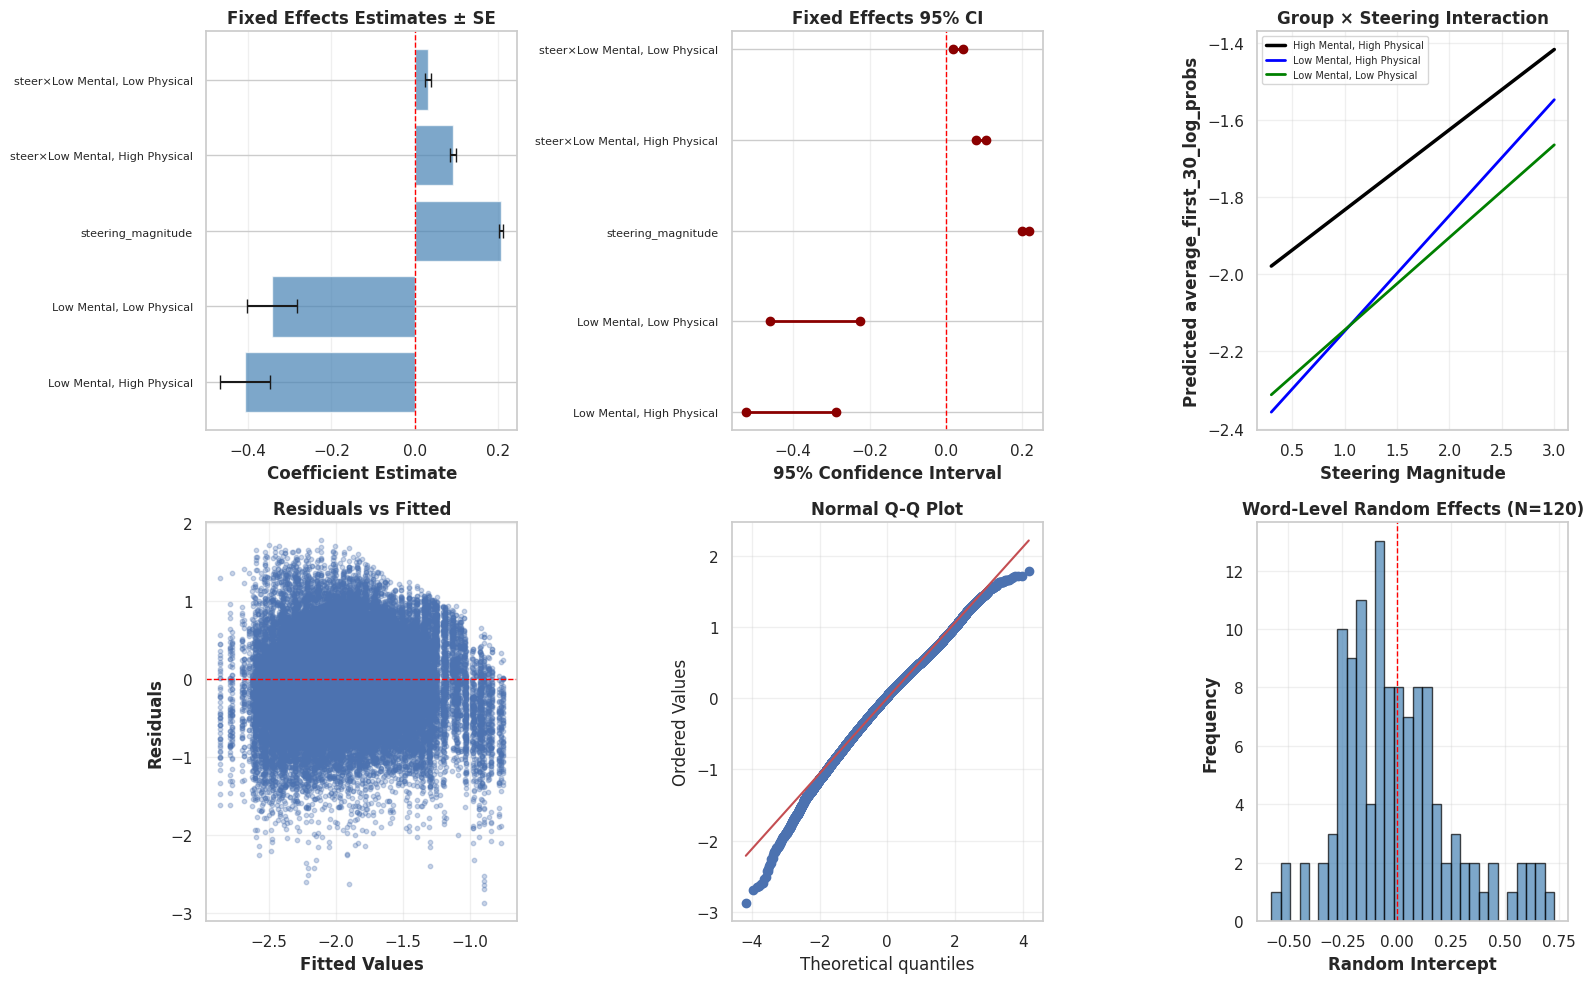


Visualization saved to plots/lmm_analysis.png


In [12]:
# ============================================================================
# Execute LMER Analysis for avg_response, average_first_30_log_probs
# ============================================================================

# Load word_guess_steered data

df = pd.read_csv(DATA_FOLDER + 'avg_response.csv')
df['average_first_30_log_probs'] = df['first_100_response_log_probs'].apply(lambda x: sum(ast.literal_eval(x)[:30]) / 30)

# Merge datasets
df_merged = df.merge(
    words_df[['word', 'group']], 
    left_on='role_name', 
    right_on='word', 
    how='left'
)


print("=== DATA LOADING ===")
print(f"Original rows: {len(df)}")
print(f"Merged rows: {len(df_merged)}")
print(f"Rows with group: {df_merged['group'].notna().sum()}")
print(f"Unique words: {df_merged['role_name'].nunique()}")
print(f"Unique tasks: {df_merged['task_name'].unique()}")

# Check for unmapped words
missing_words = df[~df['role_name'].isin(words_df['word'])]['role_name'].unique()
if len(missing_words) > 0:
    print(f"\nWARNING: Unmapped words: {missing_words}")

# Run LMER analysis
lmm_result = run_lmer_analysis(
    df_merged=df_merged,
    output_column='average_first_30_log_probs',
    output_dir=OUTPUT_DIR,
    reference_group='High Mental, High Physical',
    model_tasks = False,
)

In [15]:
(0.2083 + 0.0921) / 0.2083

1.4421507441190589

## Word Guess

=== DATA LOADING ===
Original rows: 4356
Merged rows: 4356
Rows with group: 4356
Unique words: 121
Unique tasks: ['think_of_word' 'give_noun' 'steering_guess' 'steering_introspection']
=== DATA SUMMARY ===
Total rows: 4320
Rows with group: 4320
Unique words: 120
Unique tasks: 4

=== GROUP DISTRIBUTION ===
                            n_words  n_obs  mean_average_log_probs  \
group                                                                
High Mental, High Physical       40   1440                  -6.871   
Low Mental, High Physical        40   1440                  -6.265   
Low Mental, Low Physical         40   1440                  -6.729   

                            std_average_log_probs  
group                                              
High Mental, High Physical                  2.225  
Low Mental, High Physical                   2.621  
Low Mental, Low Physical                    2.957  

=== STEERING MAGNITUDES ===
Magnitudes: [np.float64(0.0), np.float64(0.3), np.flo

/tmp/ipykernel_493323/919907580.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_summary = df_model.groupby('group').agg({
/tmp/ipykernel_493323/919907580.py:229: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  re_vals = [re[k][0] for k in sorted(re.keys())]


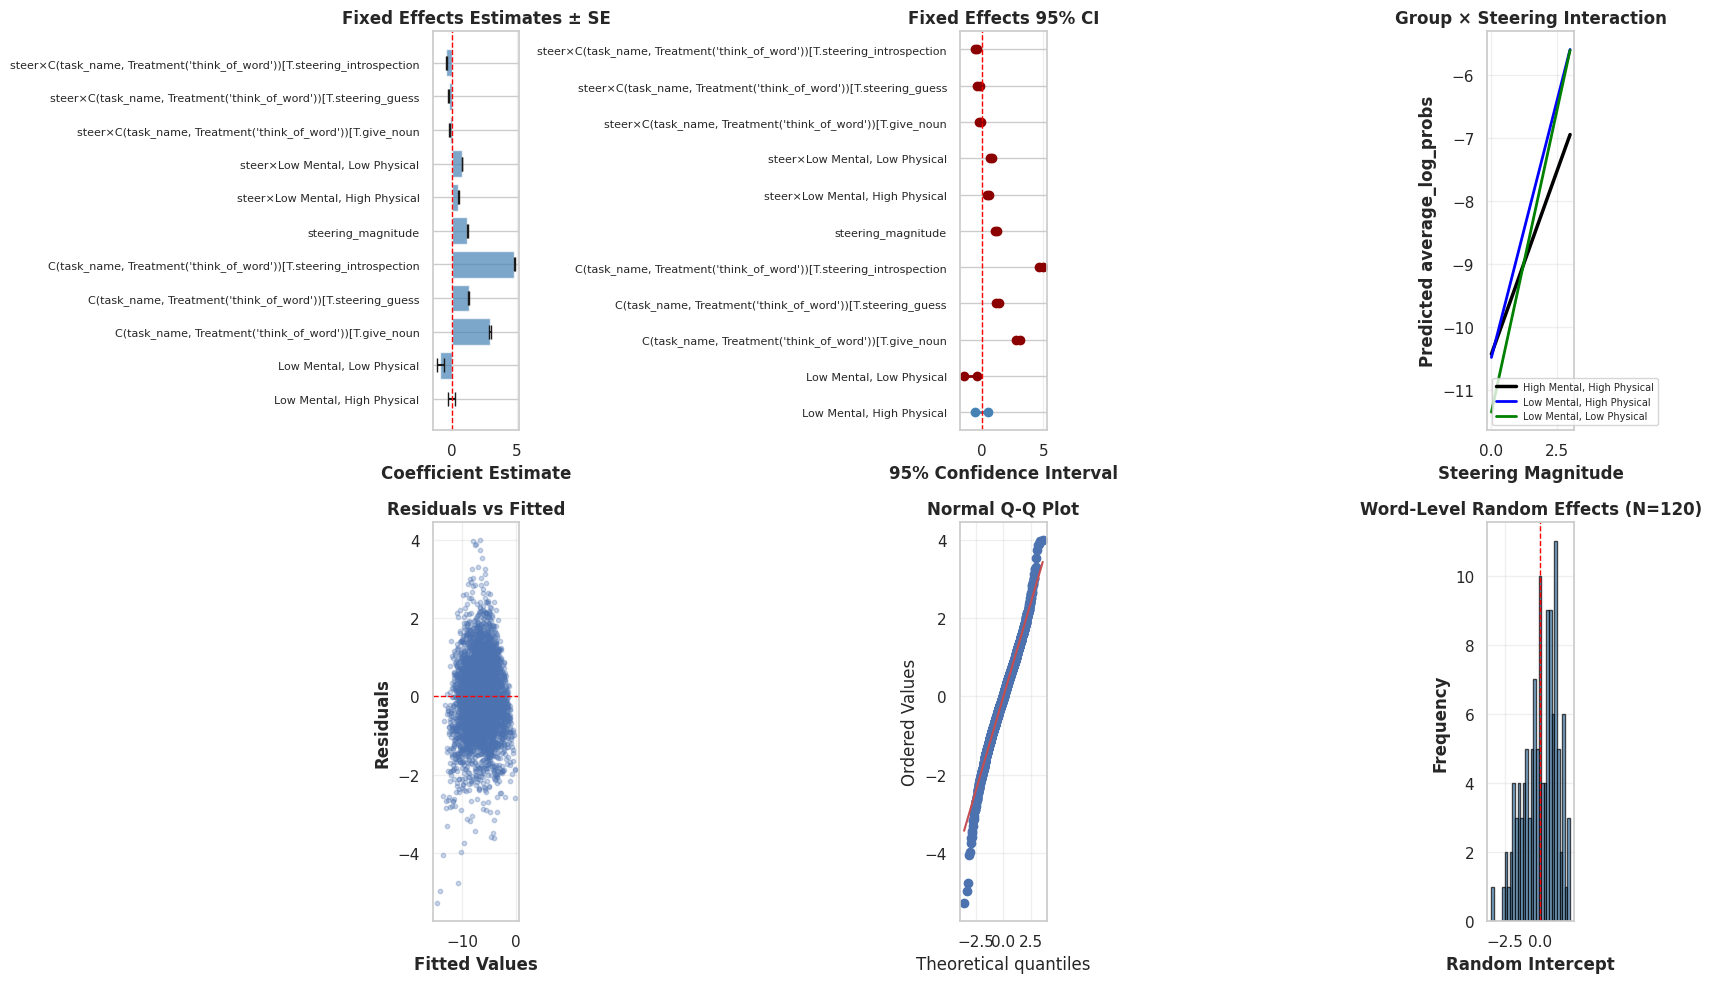


Visualization saved to plots/lmm_analysis.png


In [13]:
# ============================================================================
# Execute LMER Analysis for avg_response, average_log_probs
# ============================================================================

# Load word_guess_steered data
WORD_GUESS_FOLDER = '../data/Qwen3-30B-A3B-Instruct-2507/word_guess_steered/'
df_wg = pd.read_csv(WORD_GUESS_FOLDER + 'avg_response.csv')

# Merge datasets
df_merged = df_wg.merge(
    words_df[['word', 'group']], 
    left_on='role_name', 
    right_on='word', 
    how='left'
)

for (magnitude, role_name), group in df_merged.groupby(
    ["steering_magnitude", "role_name"], sort=False
):
    for idx, row_idx in enumerate(group.index):
        task_idx = idx % len(task_names)
        df_merged.loc[row_idx, "task_name"] = task_names[task_idx]

print("=== DATA LOADING ===")
print(f"Original rows: {len(df_wg)}")
print(f"Merged rows: {len(df_merged)}")
print(f"Rows with group: {df_merged['group'].notna().sum()}")
print(f"Unique words: {df_merged['role_name'].nunique()}")
print(f"Unique tasks: {df_merged['task_name'].unique()}")

# Check for unmapped words
missing_words = df_wg[~df_wg['role_name'].isin(words_df['word'])]['role_name'].unique()
if len(missing_words) > 0:
    print(f"\nWARNING: Unmapped words: {missing_words}")

# Run LMER analysis
lmm_result = run_lmer_analysis(
    df_merged=df_merged,
    output_column='average_log_probs',
    output_dir=OUTPUT_DIR,
    reference_group='High Mental, High Physical'
)

=== DATA LOADING ===
Original rows: 4356
Merged rows: 4356
Rows with group: 4356
Unique words: 121
Unique tasks: ['think_of_word' 'give_noun' 'steering_guess' 'steering_introspection']
=== DATA SUMMARY ===
Total rows: 4320
Rows with group: 4320
Unique words: 120
Unique tasks: 4

=== GROUP DISTRIBUTION ===
                            n_words  n_obs  mean_average_log_probs  \
group                                                                
High Mental, High Physical       40   1440                  -7.303   
Low Mental, High Physical        40   1440                  -7.313   
Low Mental, Low Physical         40   1440                  -7.896   

                            std_average_log_probs  
group                                              
High Mental, High Physical                  2.384  
Low Mental, High Physical                   2.607  
Low Mental, Low Physical                    2.869  

=== STEERING MAGNITUDES ===
Magnitudes: [np.float64(0.0), np.float64(0.3), np.flo

/tmp/ipykernel_493323/919907580.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_summary = df_model.groupby('group').agg({
/tmp/ipykernel_493323/919907580.py:229: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  re_vals = [re[k][0] for k in sorted(re.keys())]


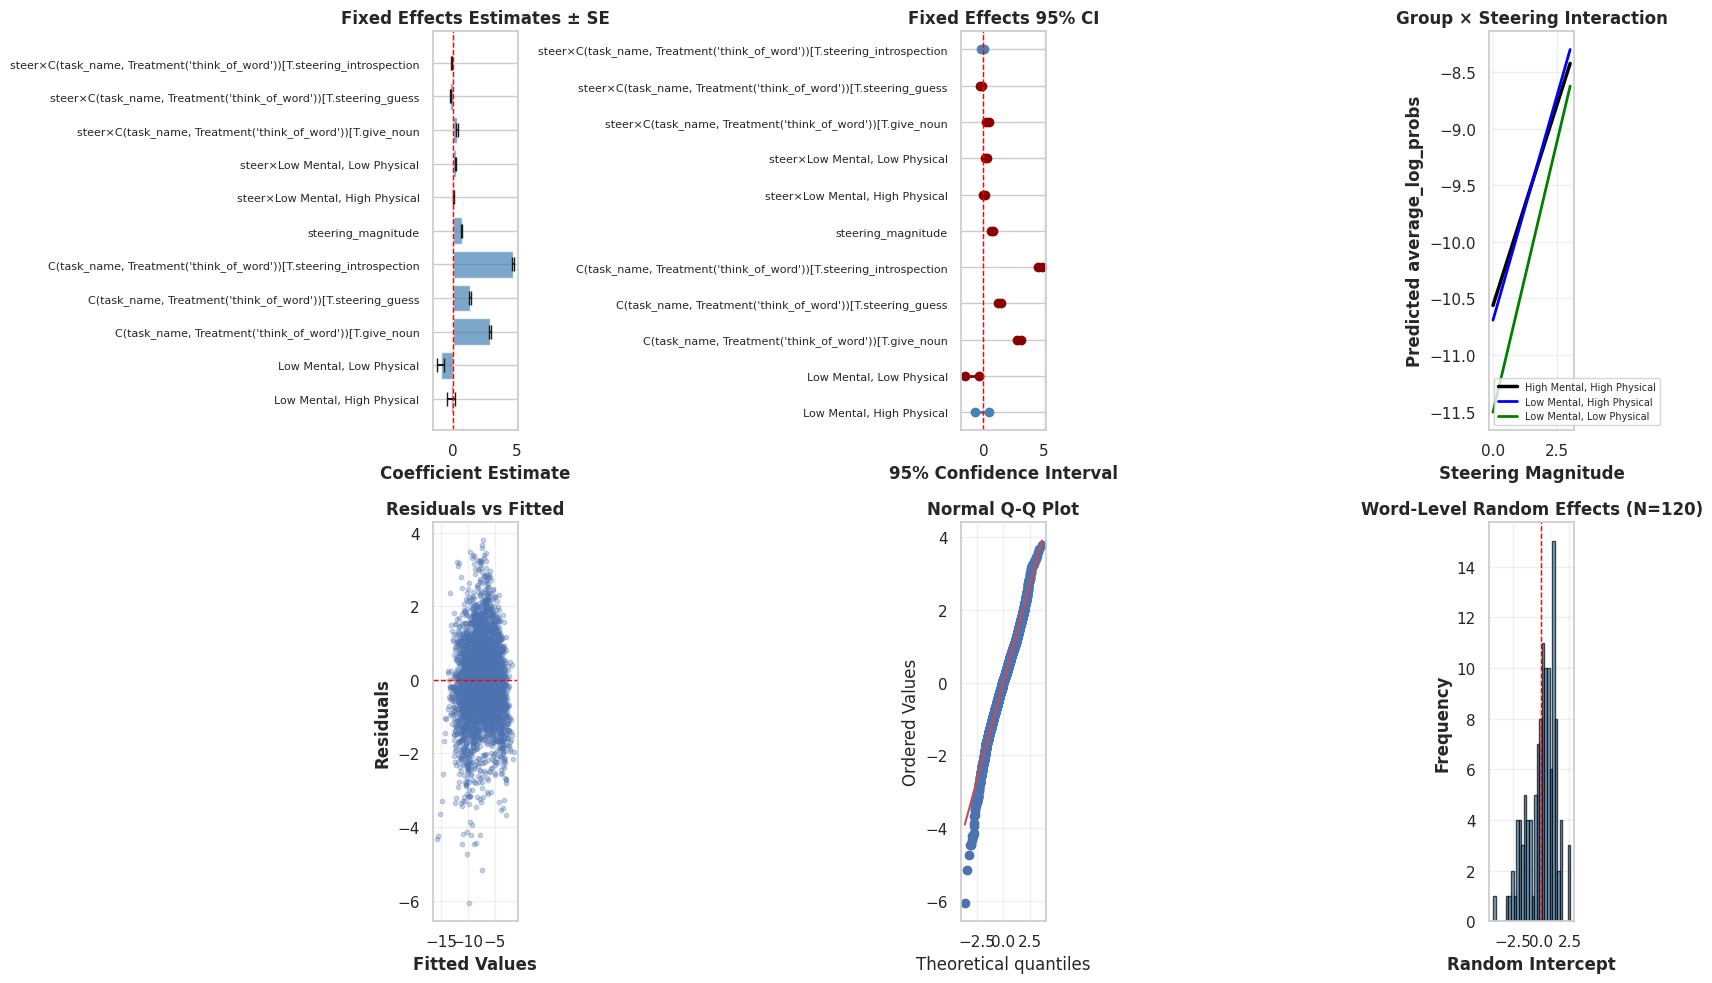


Visualization saved to plots/lmm_analysis.png


In [14]:
# ============================================================================
# Execute LMER Analysis for avg_response, average_log_probs
# ============================================================================

# Load word_guess_steered data
WORD_GUESS_FOLDER = '../data/Qwen3-30B-A3B-Instruct-2507/word_guess_steered/'
df_wg = pd.read_csv(WORD_GUESS_FOLDER + 'avg_response_first_10_sys_diff.csv')

# Merge datasets
df_merged = df_wg.merge(
    words_df[['word', 'group']], 
    left_on='role_name', 
    right_on='word', 
    how='left'
)

for (magnitude, role_name), group in df_merged.groupby(
    ["steering_magnitude", "role_name"], sort=False
):
    for idx, row_idx in enumerate(group.index):
        task_idx = idx % len(task_names)
        df_merged.loc[row_idx, "task_name"] = task_names[task_idx]

print("=== DATA LOADING ===")
print(f"Original rows: {len(df_wg)}")
print(f"Merged rows: {len(df_merged)}")
print(f"Rows with group: {df_merged['group'].notna().sum()}")
print(f"Unique words: {df_merged['role_name'].nunique()}")
print(f"Unique tasks: {df_merged['task_name'].unique()}")

# Check for unmapped words
missing_words = df_wg[~df_wg['role_name'].isin(words_df['word'])]['role_name'].unique()
if len(missing_words) > 0:
    print(f"\nWARNING: Unmapped words: {missing_words}")

# Run LMER analysis
lmm_result = run_lmer_analysis(
    df_merged=df_merged,
    output_column='average_log_probs',
    output_dir=OUTPUT_DIR,
    reference_group='High Mental, High Physical'
)